# Import library and load data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("data/corn_price.xlsx")

In [3]:
df.tail()

,date,close
3188,2024-10-04,424.75
3189,2024-10-07,426.00
3190,2024-10-08,420.75
3191,2024-10-09,421.00
3192,2024-10-10,418.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3193 non-null   datetime64[ns]
 1   close   3193 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.0 KB


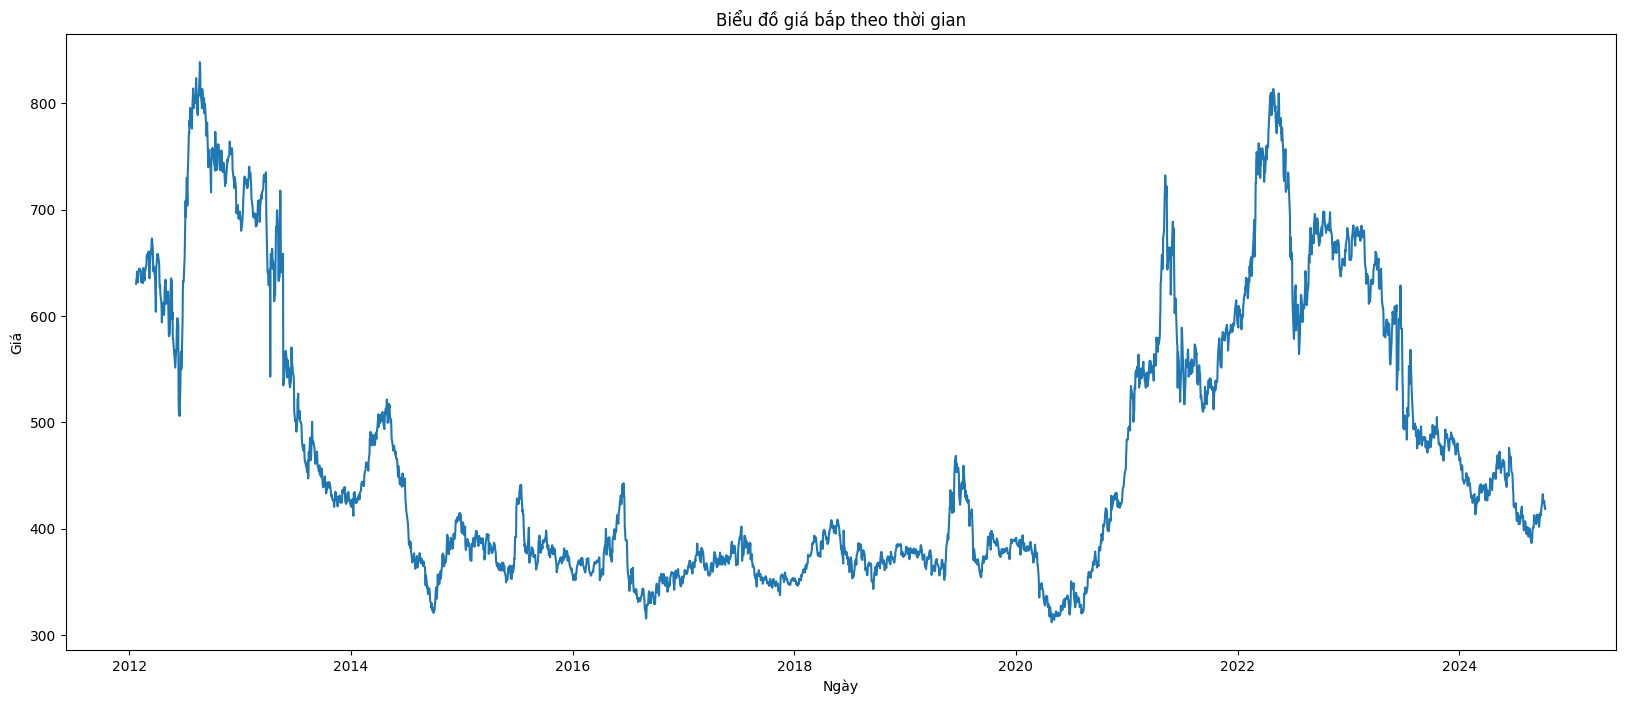

In [5]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(df['date'], df['close'])
ax.set_xlabel('Ngày')
ax.set_ylabel('Giá')
ax.set_title('Biểu đồ giá bắp theo thời gian')
plt.show()

# Thống kê mô tả

In [6]:
df.describe()

,date,close
count,3193,3193.000000
mean,2018-05-31 11:28:39.386157312,472.339806
min,2012-01-24 00:00:00,312.000000
25%,2015-03-25 00:00:00,371.000000
50%,2018-05-24 00:00:00,420.500000
75%,2021-08-10 00:00:00,561.500000
max,2024-10-10 00:00:00,838.750000
std,NaN,130.038973


In [7]:
df.duplicated().sum()

0

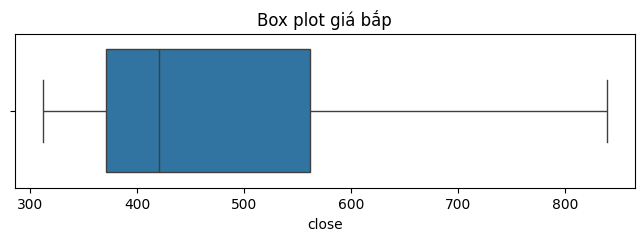

In [8]:
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=df['close'])
ax.set_title('Box plot giá bắp')
plt.show()

In [9]:
mean = df['close'].mean()
std_dev = df['close'].std()
df['z_score'] = (df['close'] - mean) / std_dev

# Xác định giá trị ngoại lệ
threshold = 3
outliers = df[(df['z_score'] > threshold) | (df['z_score'] < -threshold)]

print("Các dòng giá trị ngoại lệ:")
print(outliers)

Các dòng giá trị ngoại lệ:
Empty DataFrame
Columns: [date, close, z_score]
Index: []


In [10]:
mean = np.mean(df['close']).round(3)
mode = list(df['close'].mode().round(3))
median = np.median(df['close']).round(3)
data_range = np.ptp(df['close'])
variance = np.var(df['close'], ddof=1).round(3)
std_deviation = np.std(df['close'], ddof=1).round(3)
skewness = skew(df['close']).round(2)
kurt = kurtosis(df['close']).round(2)
print(f'Các đại lượng về xu thế trung tâm của giá bắp')
print(f'Mean: {mean}')
print(f'Mode: {mode}')
print(f'Median: {median}')
print('')
print(f'Các đại lượng về độ phân tán của giá bắp')
print(f'Khoảng biến thiên (Range): {data_range}')
print(f'Phương sai (Variance): {variance}')
print(f'Độ lệch chuẩn (Standard deviation): {std_deviation}')
print('')
print(f'Các đại lượng về hình dáng phân phối của giá bắp')
print(f'Độ lệch: {skewness}')
print(f'Độ nhọn: {kurt}')

Các đại lượng về xu thế trung tâm của giá bắp
Mean: 472.34
Mode: [368.25, 373.25, 377.25]
Median: 420.5

Các đại lượng về độ phân tán của giá bắp
Khoảng biến thiên (Range): 526.75
Phương sai (Variance): 16910.134
Độ lệch chuẩn (Standard deviation): 130.039

Các đại lượng về hình dáng phân phối của giá bắp
Độ lệch: 0.93
Độ nhọn: -0.37


<Figure size 800x200 with 0 Axes>

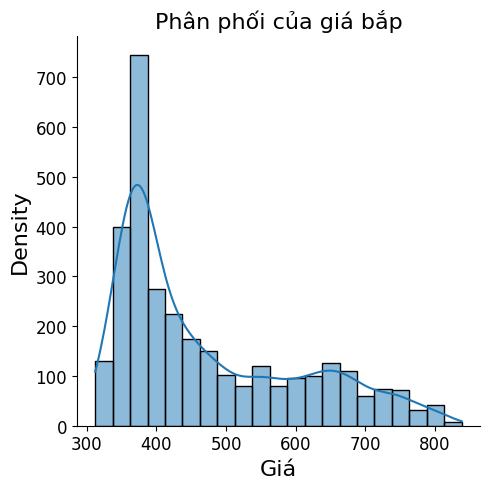

In [11]:
plt.figure(figsize=(8,2))
sns.displot(df['close'], kde = True)
plt.title(f'Phân phối của giá bắp',fontsize = 16)
plt.xlabel('Giá',fontsize = 16)
plt.ylabel('Density',fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

# LSTM

## Class CNNLSTMPredictor

In [13]:
class CNNLSTMPredictor:
    def __init__(self, n_steps=10, n_seq=2, n_features=1):
        self.n_steps = n_steps
        self.n_seq = n_seq
        self.n_features = n_features
        self.scaler = MinMaxScaler()

# Tiền xử lý trước khi đưa dữ liệu vào mô hình
    def create_sequences(self, data):
        length = len(data)
        X = np.array([data[i:i+self.n_steps] for i in range(length-self.n_steps)])
        y = np.array([data[i+self.n_steps] for i in range(length-self.n_steps)])
        # Reshape X to (samples, n_seq, timesteps_per_seq, features)
        return X.reshape((X.shape[0], self.n_seq, self.n_steps//self.n_seq, self.n_features)), y
    
    def prepare_data(self, df, train_size=0.7, val_size=0.15):
        """Prepare and split data into train, validation and test sets"""
        
        # Xử lý cột ngày
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
        # Xử lý cột giá
        prices = df['close'].values.reshape(-1, 1)
        scaled_prices = self.scaler.fit_transform(prices)
        
        X, y = self.create_sequences(scaled_prices)
        
        # Chia dữ liệu thành tập train, validation, test
        train_end = int(len(X) * train_size)
        val_end = int(len(X) * (train_size + val_size))
        
        self.X_train, self.y_train = X[:train_end], y[:train_end]
        self.X_val, self.y_val = X[train_end:val_end], y[train_end:val_end]
        self.X_test, self.y_test = X[val_end:], y[val_end:]
        
        self.dates = df['date'].values[self.n_steps:]
        self.train_dates = self.dates[:train_end]
        self.val_dates = self.dates[train_end:val_end]
        self.test_dates = self.dates[val_end:]
        
        return (self.X_train, self.y_train), (self.X_val, self.y_val), (self.X_test, self.y_test)

# Xây dựng mô hình  
    def build_model(self, conv_filters=128, conv_kernel_size=3, conv_activation='relu', lstm_units=50, lstm_activation = 'relu', learning_rate=0.001):
        """Build CNN-LSTM model with given parameters"""
        model = Sequential([
            # Apply Conv1D to each sequence separately using TimeDistributed
            TimeDistributed(
                Conv1D(
                    filters=conv_filters,
                    kernel_size=conv_kernel_size,
                    activation=conv_activation
                ),
                input_shape=(self.n_seq, self.n_steps//self.n_seq, self.n_features)
            ),
            TimeDistributed(MaxPooling1D(pool_size=2)),
            TimeDistributed(Flatten()),
            LSTM(lstm_units, activation=lstm_activation),
            Dense(1)
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=Huber(delta=1.0),
            metrics=['mae']
        )
        return model
    
# Train để đánh giá mô hình
    def train_model(self, model, X_train, y_train, X_val, y_val, 
                    epochs=500, batch_size=32, patience=50):
        """Train model with early stopping and model checkpointing"""
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint('best_CNNLSTM_model.keras', monitor='val_loss', save_best_only=True)
        ]
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return history

# Kết quả
    def forecasting_result(self, model, X, y):
        forecasting = model.predict(X)
        actual = self.scaler.inverse_transform(y.reshape(-1, 1))
        forecasting = self.scaler.inverse_transform(forecasting)
        return actual, forecasting
    
# Plot
    def plot_loss_by_epoch(self, history):
        """Plot training and validation metrics over epochs"""
        plt.figure(figsize=(14, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_forcasting(self, dates, y_true, y_pred, title='Actual Prices vs. Predicted Prices'):
        plt.figure(figsize=(15, 6))
        plt.plot(dates, y_true, label='Actual')
        plt.plot(dates, y_pred, label='Predict')

        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

    def plot_train_validation_test_forecasting(self, model):
        """Plot predictions for all datasets"""
        # Training set
        y_train_orig, train_pred = self.forecasting_result(model, self.X_train, self.y_train)
        print("\nTraining Set Predictions:")
        self.plot_forcasting(self.train_dates, y_train_orig, train_pred, 
                            "Training Set: Actual vs Predicted")
        
        # Validation set
        y_val_orig, val_pred = self.forecasting_result(model, self.X_val, self.y_val)
        print("\nValidation Set Predictions:")
        self.plot_forcasting(self.val_dates, y_val_orig, val_pred,
                            "Validation Set: Actual vs Predicted")
        
        # Test set
        y_test_orig, test_pred = self.forecasting_result(model, self.X_test, self.y_test)
        print("\nTest Set Predictions:")
        self.plot_forcasting(self.test_dates, y_test_orig, test_pred,
                            "Test Set: Actual vs Predicted")

# Forecast
    def forecast_future(self, model, last_sequence, n_predictions=30):
        predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_predictions):
            # Dự đoán bước tiếp theo
            pred = model.predict(
                current_sequence.reshape(1, self.n_seq, self.n_steps // self.n_seq, self.n_features),
                verbose=0
            )
            
            # Lưu trữ dự đoán mới
            predictions.append(pred[0, 0])

            # Chuẩn hóa giá trị dự đoán để đưa vào sequence
            pred_scaled = self.scaler.transform(pred)

            # Cập nhật current_sequence: dịch sang trái và thêm pred_scaled vào cuối
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[:, -1, :] = pred_scaled.reshape(-1, 1)

        # Chuyển đổi dự đoán về thang đo gốc
        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        return predictions

    
def create_forecasting_dataframe(df, model, predictor, X_train, X_val, X_test):
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)

    train_predictions = predictor.scaler.inverse_transform(train_predictions)
    val_predictions = predictor.scaler.inverse_transform(val_predictions)
    test_predictions = predictor.scaler.inverse_transform(test_predictions)
    
    train_dates = predictor.train_dates
    val_dates = predictor.val_dates
    test_dates = predictor.test_dates

    train_df = pd.DataFrame({
        'date': train_dates,
        'actual': df.loc[df['date'].isin(train_dates), 'close'].values,
        'predict_CNNLSTM': train_predictions.flatten()
    })
    val_df = pd.DataFrame({
        'date': val_dates,
        'actual': df.loc[df['date'].isin(val_dates), 'close'].values,
        'predict_CNNLSTM': val_predictions.flatten()
    })
    test_df = pd.DataFrame({
        'date': test_dates,
        'actual': df.loc[df['date'].isin(test_dates), 'close'].values,
        'predict_CNNLSTM': test_predictions.flatten()
    })
    
    historical_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    last_sequence = X_test[-1]  # Sử dụng sequence cuối cùng trong tập kiểm tra
    future_dates = pd.date_range(start='2024-10-11', end='2024-12-31', freq='B')  # 'B' là ngày làm việc
    future_predictions = predictor.forecast_future(model, last_sequence, len(future_dates))

    future_df = pd.DataFrame({
        'date': future_dates,
        'actual': np.nan,
        'predict_CNNLSTM': future_predictions.flatten()
    })

    result_df = pd.concat([historical_df, future_df], ignore_index=True)
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values('date').reset_index(drop=True)
    
    return result_df

def CNNLSTMforecasting(df, n_steps=10, n_seq=2):
    predictor = CNNLSTMPredictor(n_steps=n_steps, n_seq=n_seq, n_features=1)
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = predictor.prepare_data(df)
    
    model = predictor.build_model()
    
    history = predictor.train_model(
        model, X_train, y_train, X_val, y_val
    )

    #Plot loss over epoch
    predictor.plot_loss_by_epoch(history)

    return model, predictor, history, X_train, y_train, X_val, y_val, X_test, y_test

def model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mape

## Experiments with different values of n_steps

In [15]:
def n_steps_experiments(df):
    configs = [
        {'n_steps': 5, 'n_seq': 1},
        {'n_steps': 10, 'n_seq': 2},
        {'n_steps': 15, 'n_seq': 3},
        {'n_steps': 20, 'n_seq': 4},
        {'n_steps': 30, 'n_seq': 6},
    ]
    
    results = []
    
    for config in configs:
        print(f"\nTesting configuration: n_steps={config['n_steps']} (equivalent to {config['n_steps']/5:.1f} weeks)")
        print(f"Number of sequences: {config['n_seq']} (each sequence ~{config['n_steps']/config['n_seq']/5:.1f} weeks)")

        # Train model with current configuration
        model, predictor, history, X_train, y_train, X_val, y_val, X_test, y_test = CNNLSTMforecasting(df, n_steps=config['n_steps'], n_seq=config['n_seq'])

        # Get predictions for validation set
        y_val_orig, val_pred = predictor.forecasting_result(model, X_val, y_val)
        # Calculate validation metrics
        val_mae, val_rmse, val_r2, val_mape = model_metrics(y_val_orig, val_pred)

        # Get predictions for test set
        y_test_orig, test_pred = predictor.forecasting_result(model, X_test, y_test)
        # Calculate test metrics
        mae, rmse, r2, mape = model_metrics(y_test_orig, test_pred)

        results.append({
            'n_steps': config['n_steps'],
            'weeks': config['n_steps'] / 5,
            'n_seq': config['n_seq'],
            'weeks_per_seq': config['n_steps'] / config['n_seq'] / 5,
            'Val MAE': val_mae,
            'Val RMSE': val_rmse,
            'Val R2': val_r2,
            'Val MAPE': val_mape,
            'Test MAE': mae,
            'Test RMSE': rmse,
            'Test R2': r2,
            'Test MAPE': mape
        })

        # Plot predictions for validation set
        plt.figure(figsize=(15, 6))
        plt.plot(predictor.val_dates, y_val_orig, label='Actual (Validation)')
        plt.plot(predictor.val_dates, val_pred, label='Predicted (Validation)')
        plt.title(f'Validation Set Predictions\n{config["n_steps"]} days ({config["n_steps"]/5:.1f} weeks), {config["n_seq"]} sequences')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Plot predictions for test set
        plt.figure(figsize=(15, 6))
        plt.plot(predictor.test_dates, y_test_orig, label='Actual (Test)')
        plt.plot(predictor.test_dates, test_pred, label='Predicted (Test)')
        plt.title(f'Test Set Predictions\n{config["n_steps"]} days ({config["n_steps"]/5:.1f} weeks), {config["n_seq"]} sequences')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return results


Testing configuration: n_steps=5 (equivalent to 1.0 weeks)
Number of sequences: 1 (each sequence ~1.0 weeks)
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0283 - mae: 0.1522 - val_loss: 0.0022 - val_mae: 0.0583
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0967e-04 - mae: 0.0263 - val_loss: 0.0014 - val_mae: 0.0427
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0361e-04 - mae: 0.0195 - val_loss: 0.0012 - val_mae: 0.0403
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2526e-04 - mae: 0.0192 - val_loss: 0.0012 - val_mae: 0.0398
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7951e-04 - mae: 0.0183 - val_loss: 0.0011 - val_mae: 0.0371
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3820e-04 - mae: 0.0172 - val_loss: 9.9775e-04 - val_mae: 0.0358
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3718e-04 - mae: 0.0170 - val_loss: 8.5336e-04 - val_mae: 0.0320
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 

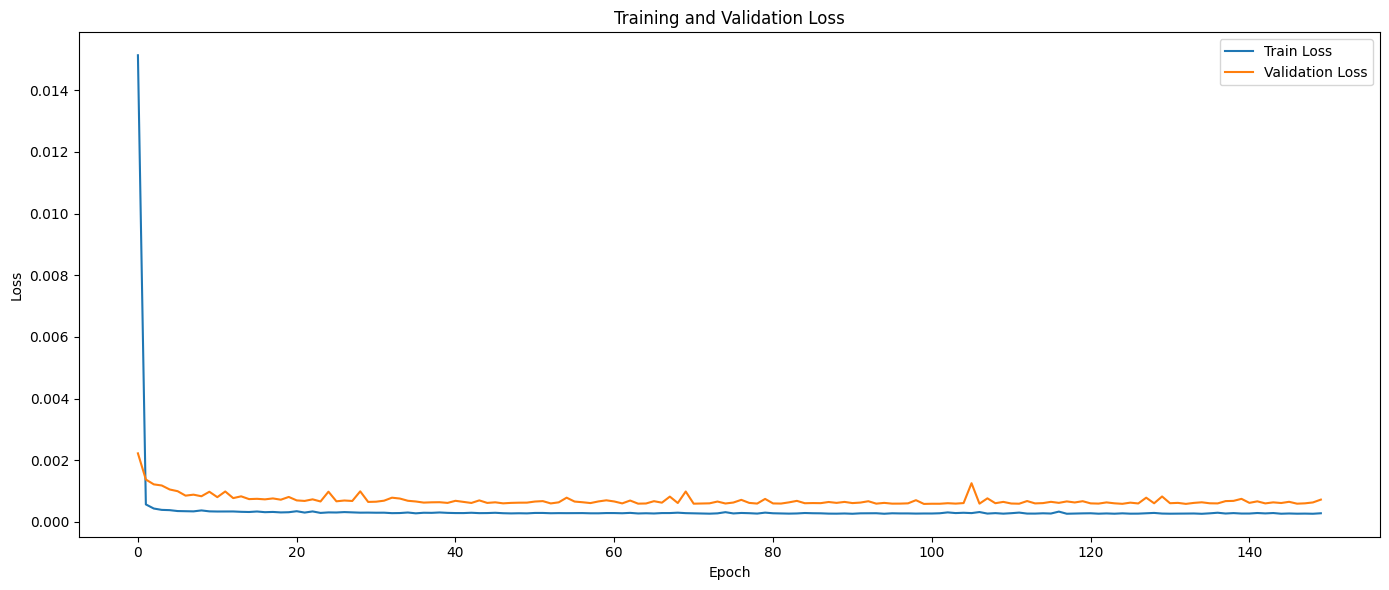

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


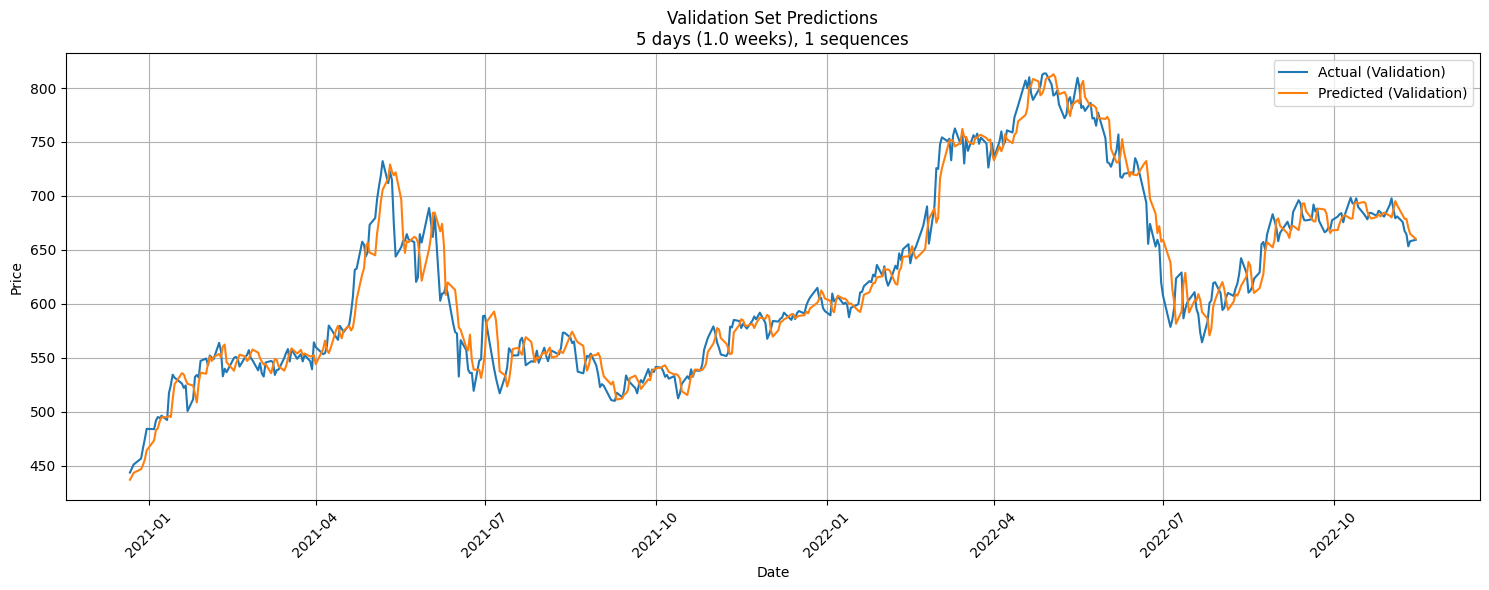

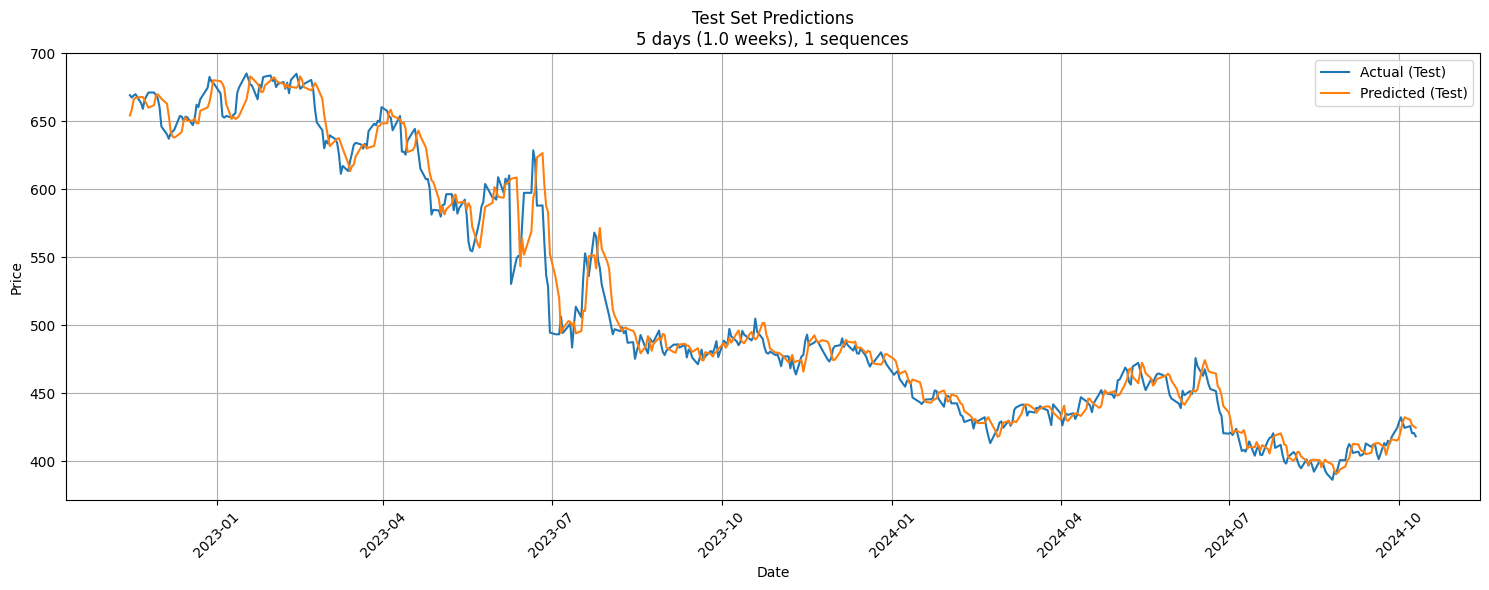


Testing configuration: n_steps=10 (equivalent to 2.0 weeks)
Number of sequences: 2 (each sequence ~1.0 weeks)
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0209 - mae: 0.1255 - val_loss: 0.0016 - val_mae: 0.0455
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9440e-04 - mae: 0.0224 - val_loss: 0.0014 - val_mae: 0.0424
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6896e-04 - mae: 0.0202 - val_loss: 0.0013 - val_mae: 0.0418
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3953e-04 - mae: 0.0198 - val_loss: 0.0013 - val_mae: 0.0406
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3061e-04 - mae: 0.0196 - val_loss: 0.0010 - val_mae: 0.0332
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0916e-04 - mae: 0.0194 - val_loss: 9.5639e-04 - val_mae: 0.0324
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6769e-04 - mae: 0.0207 - val_loss: 9.8320e-04 - val_mae: 0.0346
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━

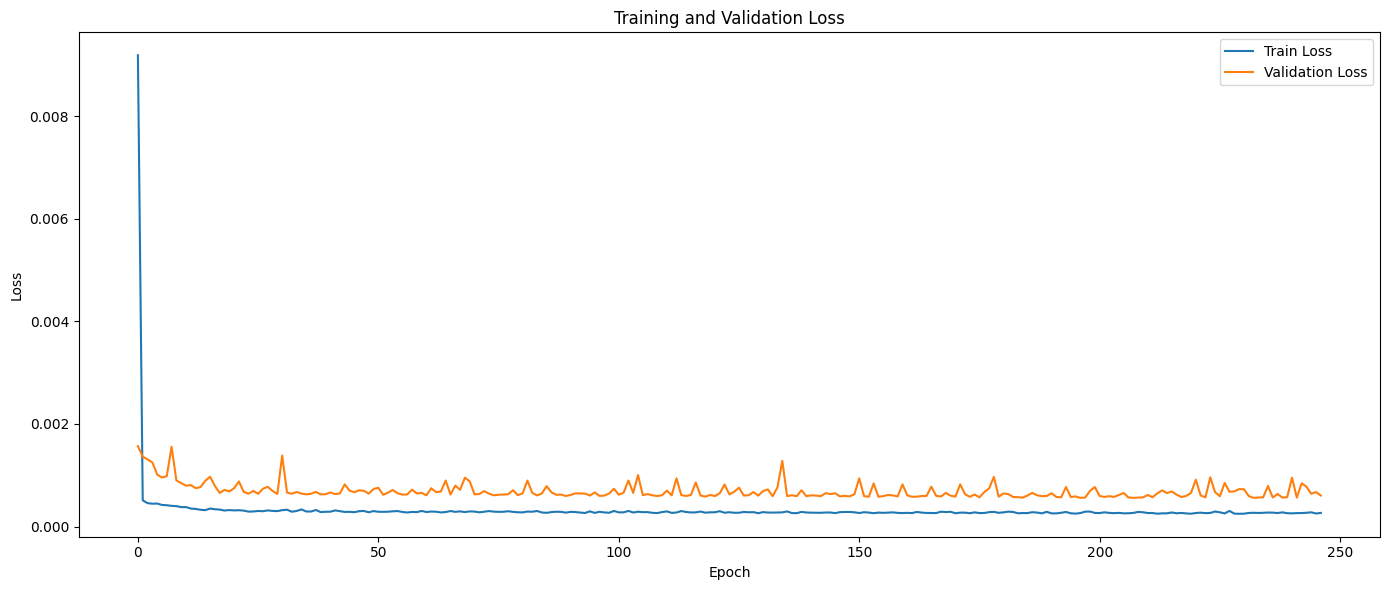

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


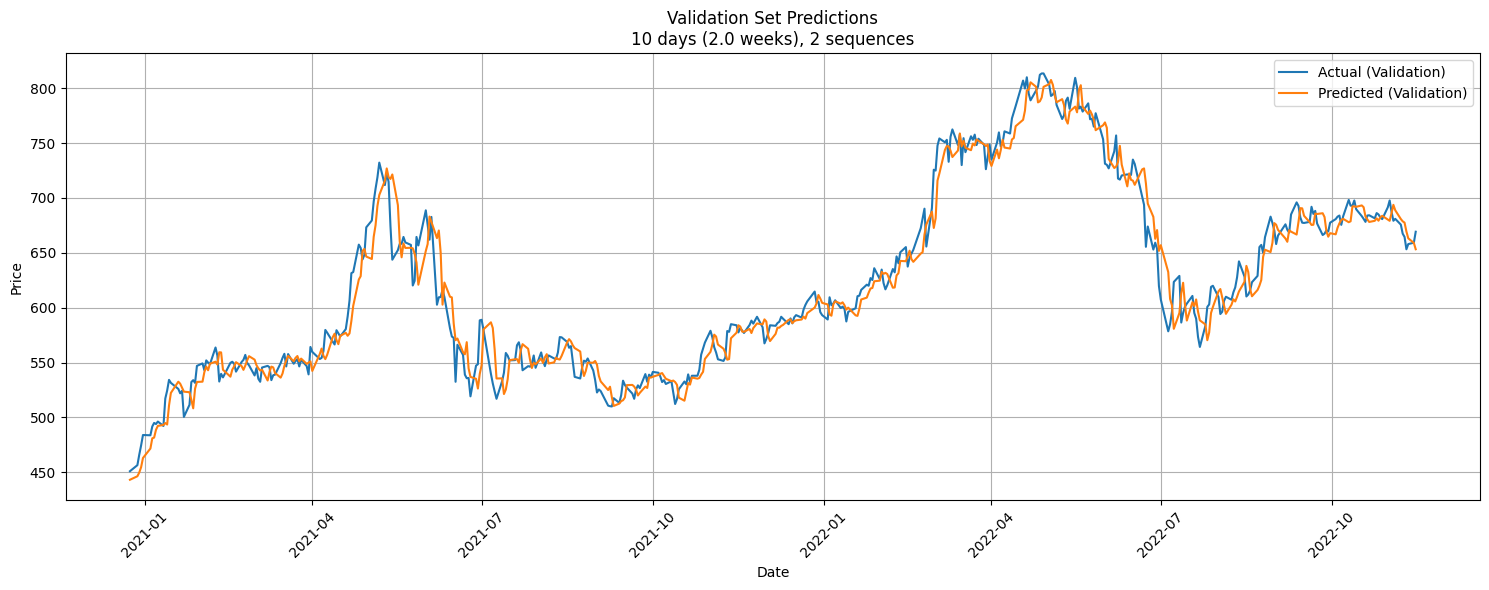

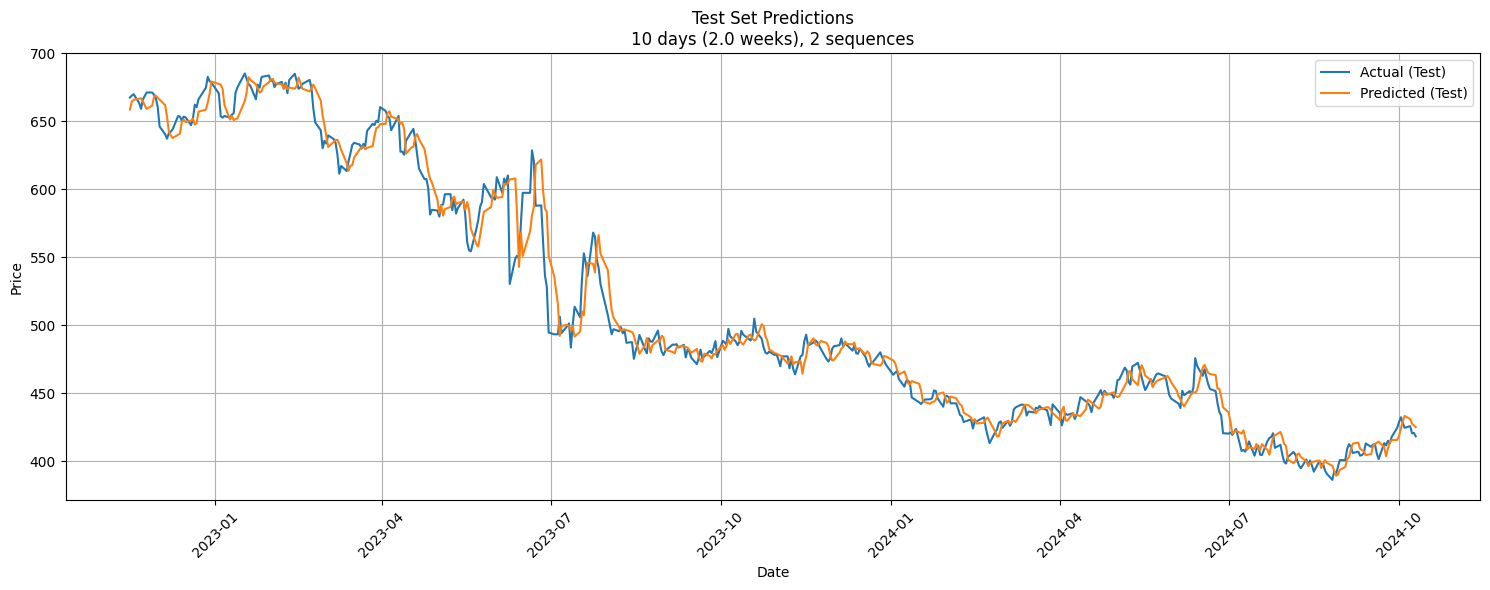


Testing configuration: n_steps=15 (equivalent to 3.0 weeks)
Number of sequences: 3 (each sequence ~1.0 weeks)
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0178 - mae: 0.1149 - val_loss: 0.0017 - val_mae: 0.0456
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9581e-04 - mae: 0.0225 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4001e-04 - mae: 0.0231 - val_loss: 0.0015 - val_mae: 0.0417
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1218e-04 - mae: 0.0224 - val_loss: 0.0015 - val_mae: 0.0427
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7191e-04 - mae: 0.0217 - val_loss: 0.0013 - val_mae: 0.0378
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9145e-04 - mae: 0.0208 - val_loss: 0.0014 - val_mae: 0.0386
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4253e-04 - mae: 0.0218 - val_loss: 0.0011 - val_mae: 0.0360
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

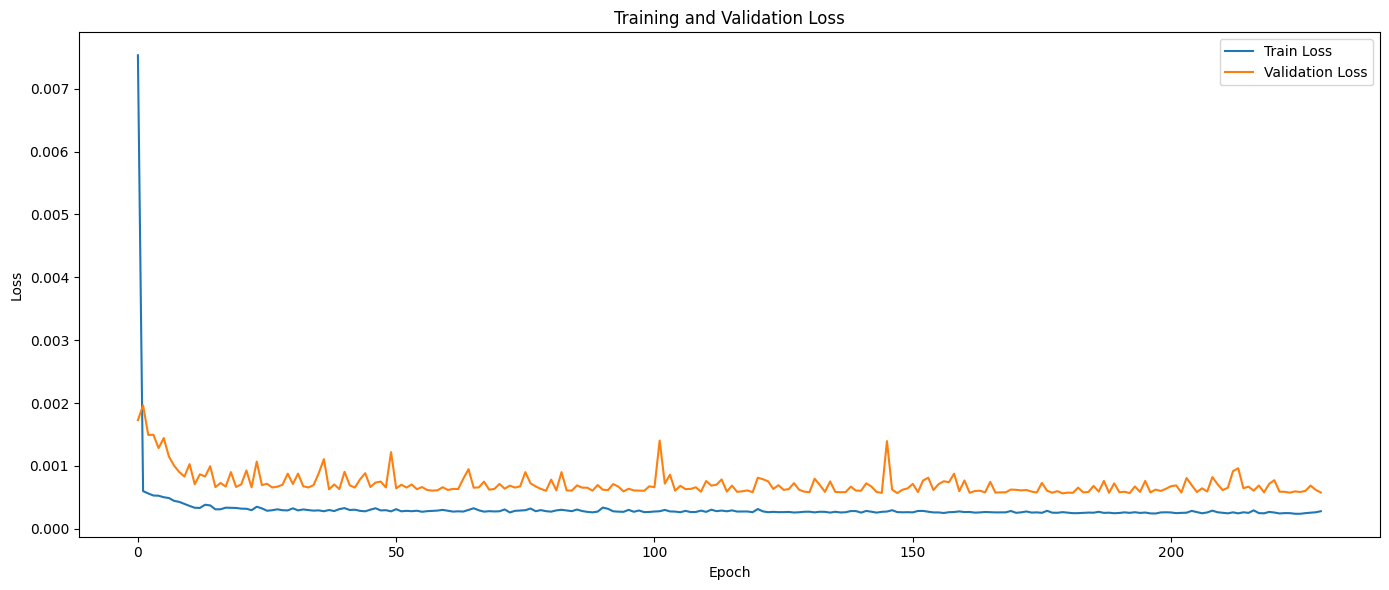

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


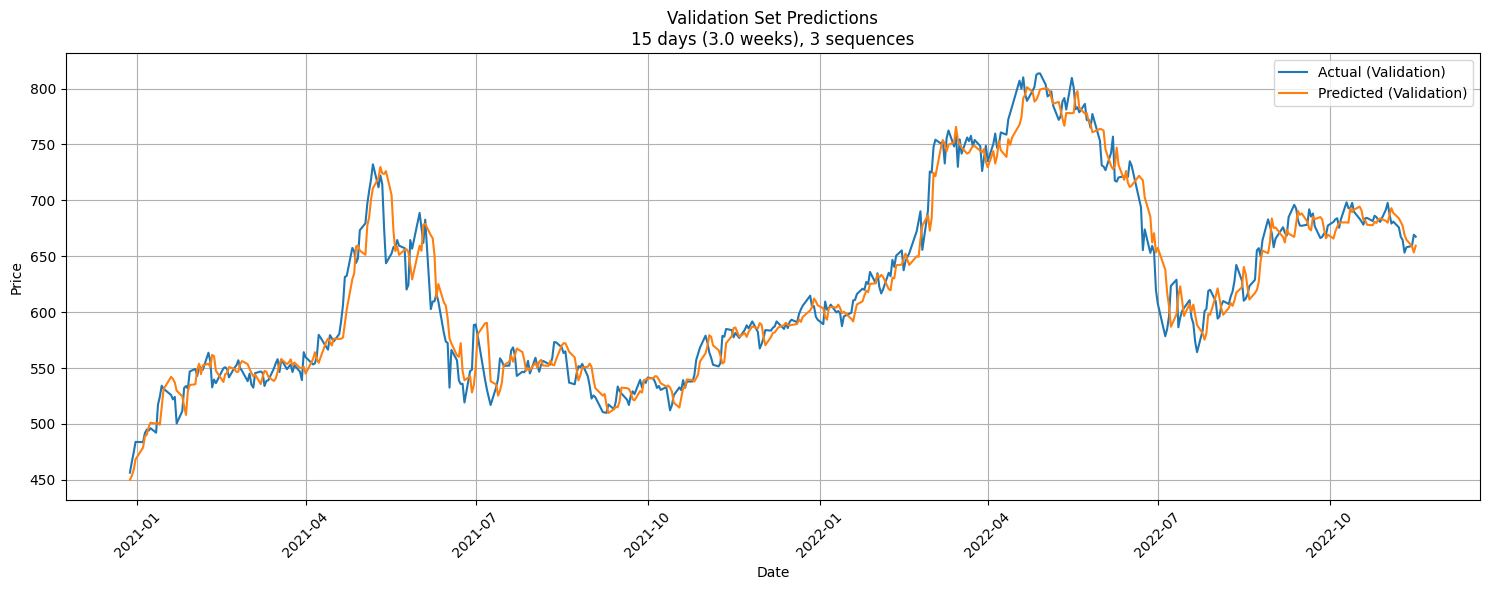

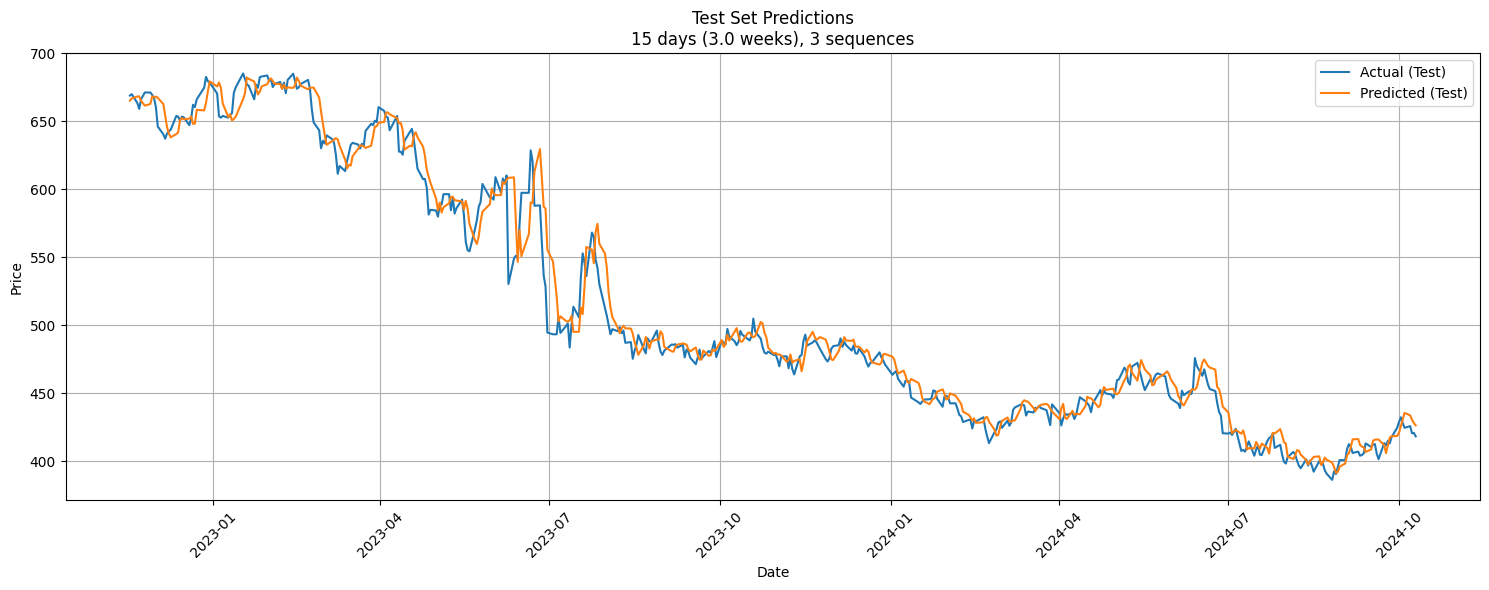


Testing configuration: n_steps=20 (equivalent to 4.0 weeks)
Number of sequences: 4 (each sequence ~1.0 weeks)
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0147 - mae: 0.1041 - val_loss: 0.0025 - val_mae: 0.0572
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8205e-04 - mae: 0.0257 - val_loss: 0.0021 - val_mae: 0.0527
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2666e-04 - mae: 0.0241 - val_loss: 0.0017 - val_mae: 0.0427
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8965e-04 - mae: 0.0224 - val_loss: 0.0016 - val_mae: 0.0446
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8575e-04 - mae: 0.0217 - val_loss: 0.0017 - val_mae: 0.0485
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1813e-04 - mae: 0.0213 - val_loss: 0.0011 - val_mae: 0.0382
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2834e-04 - mae: 0.0198 - val_loss: 9.9010e-04 - val_mae: 0.0355
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 

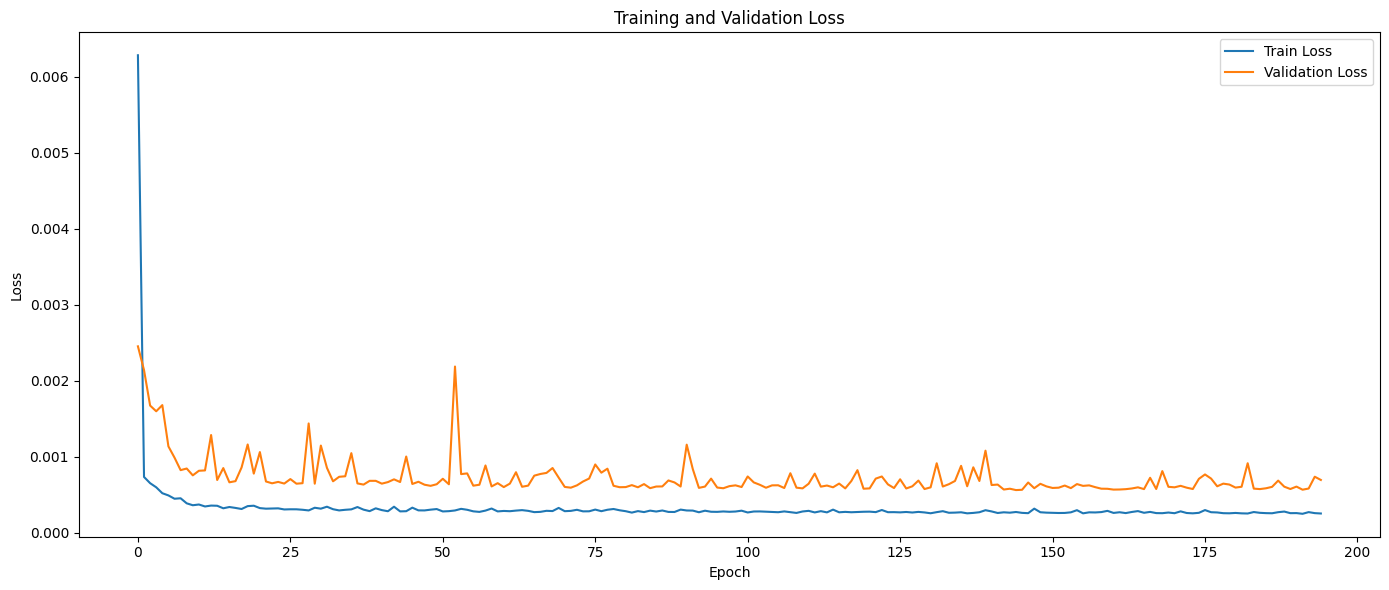

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


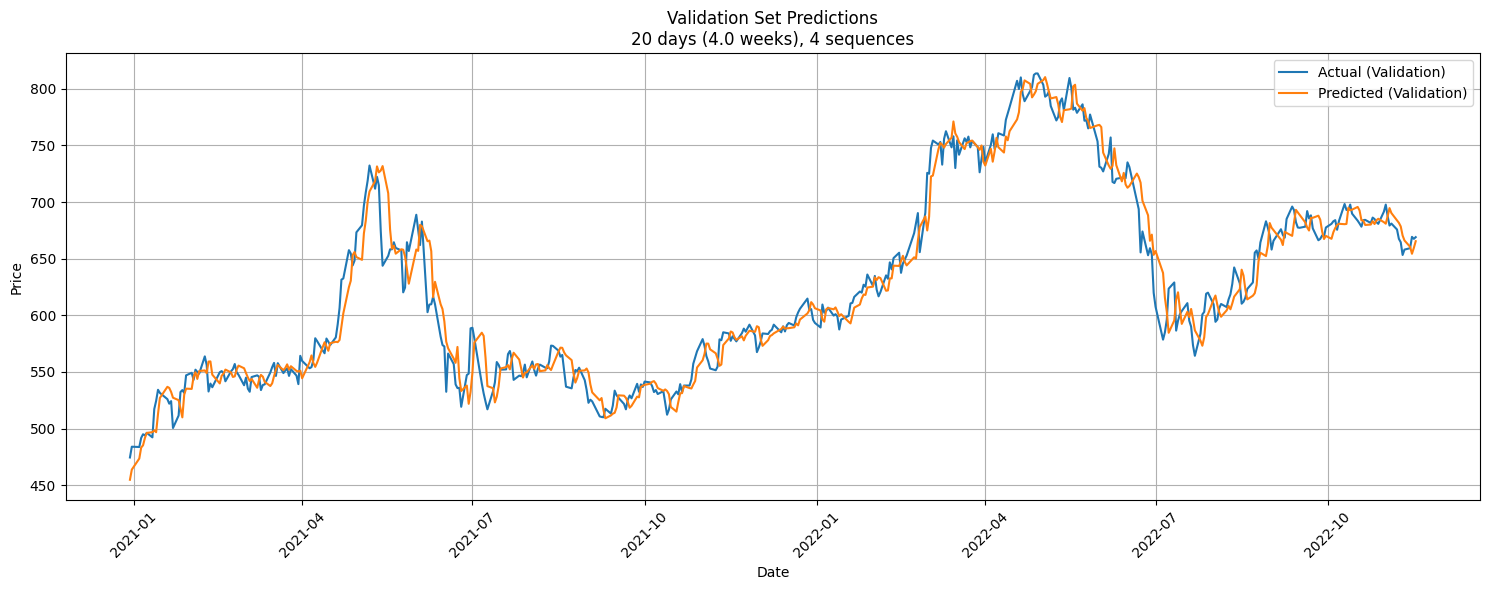

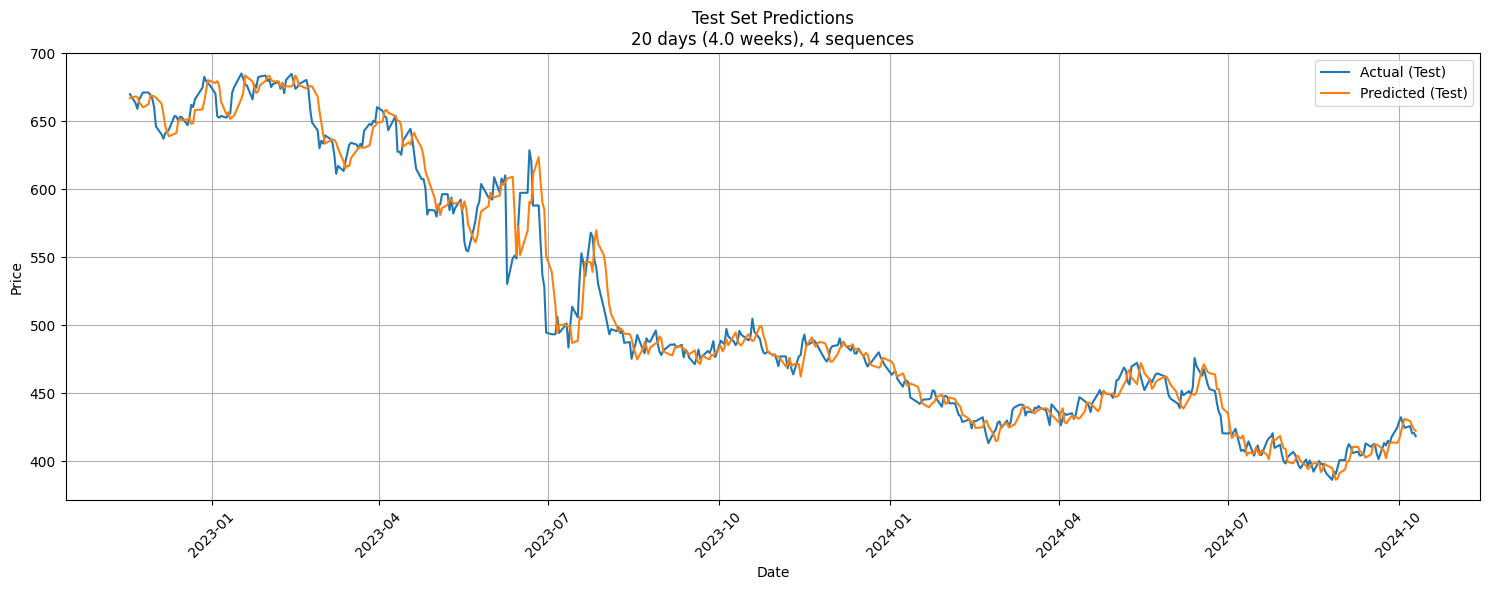


Testing configuration: n_steps=30 (equivalent to 6.0 weeks)
Number of sequences: 6 (each sequence ~1.0 weeks)
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0131 - mae: 0.0939 - val_loss: 0.0031 - val_mae: 0.0655
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5374e-04 - mae: 0.0257 - val_loss: 0.0023 - val_mae: 0.0517
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2267e-04 - mae: 0.0244 - val_loss: 0.0020 - val_mae: 0.0512
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7711e-04 - mae: 0.0224 - val_loss: 0.0010 - val_mae: 0.0334
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1157e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0528
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2477e-04 - mae: 0.0218 - val_loss: 8.9900e-04 - val_mae: 0.0329
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3885e-04 - mae: 0.0196 - val_loss: 0.0012 - val_mae: 0.0402
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 

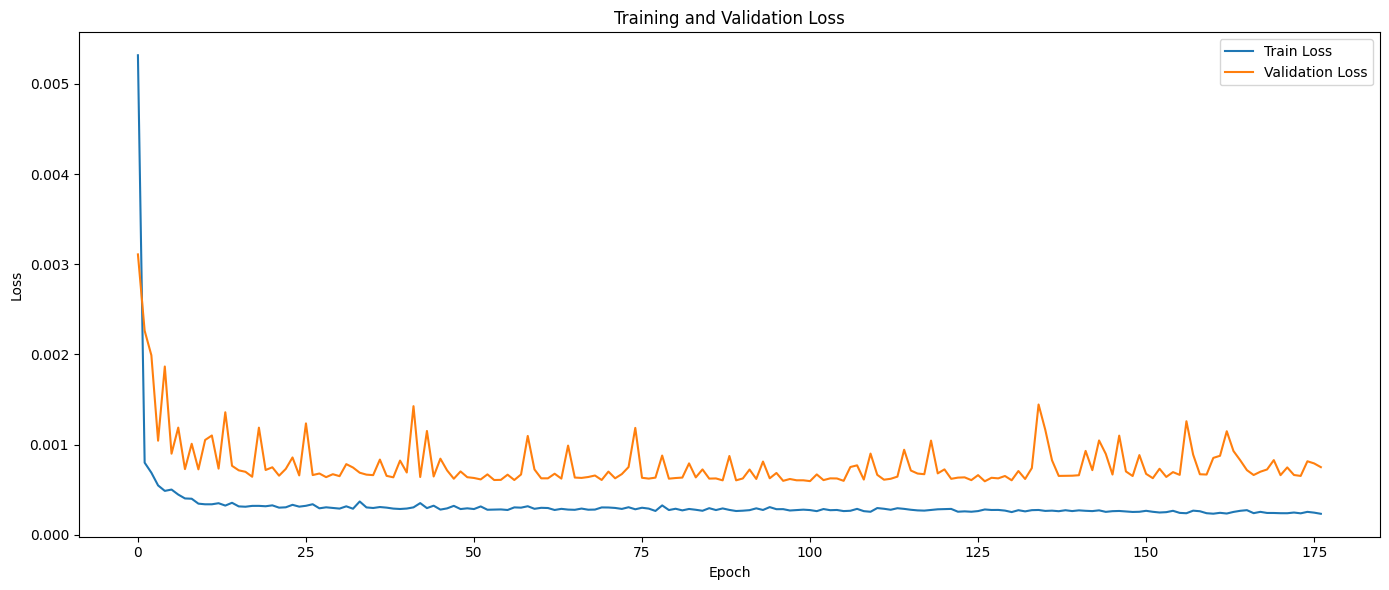

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


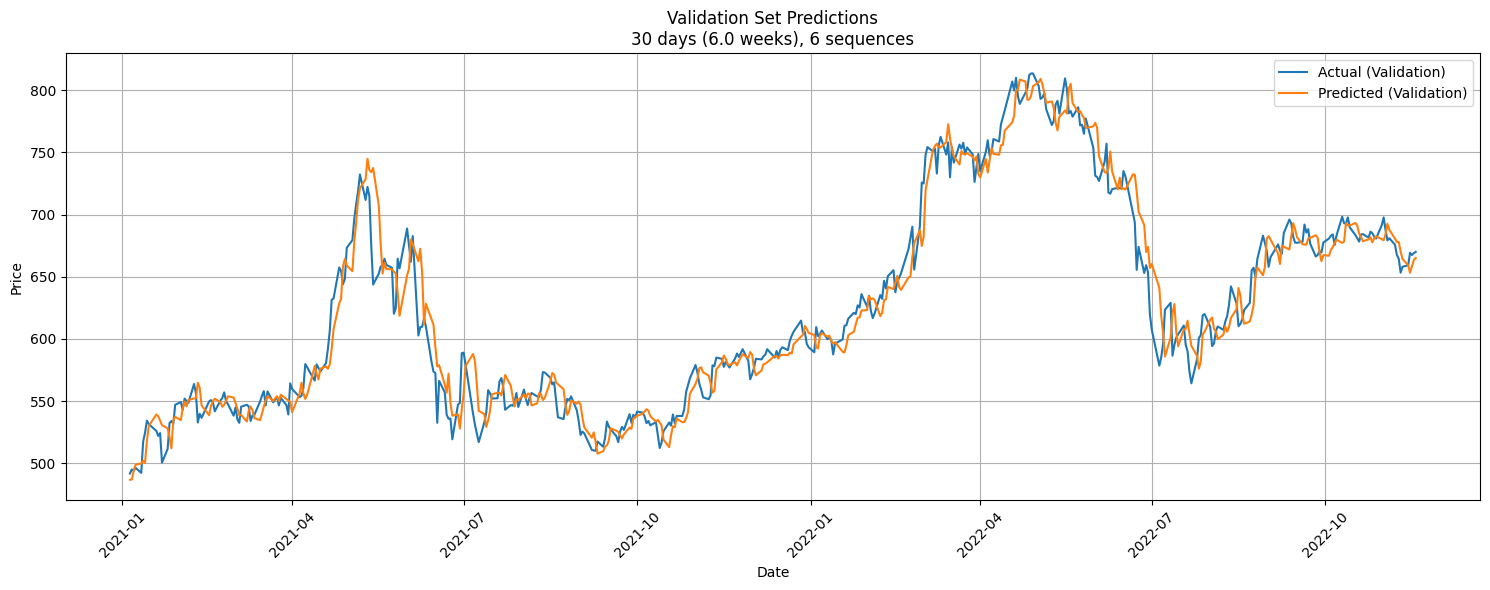

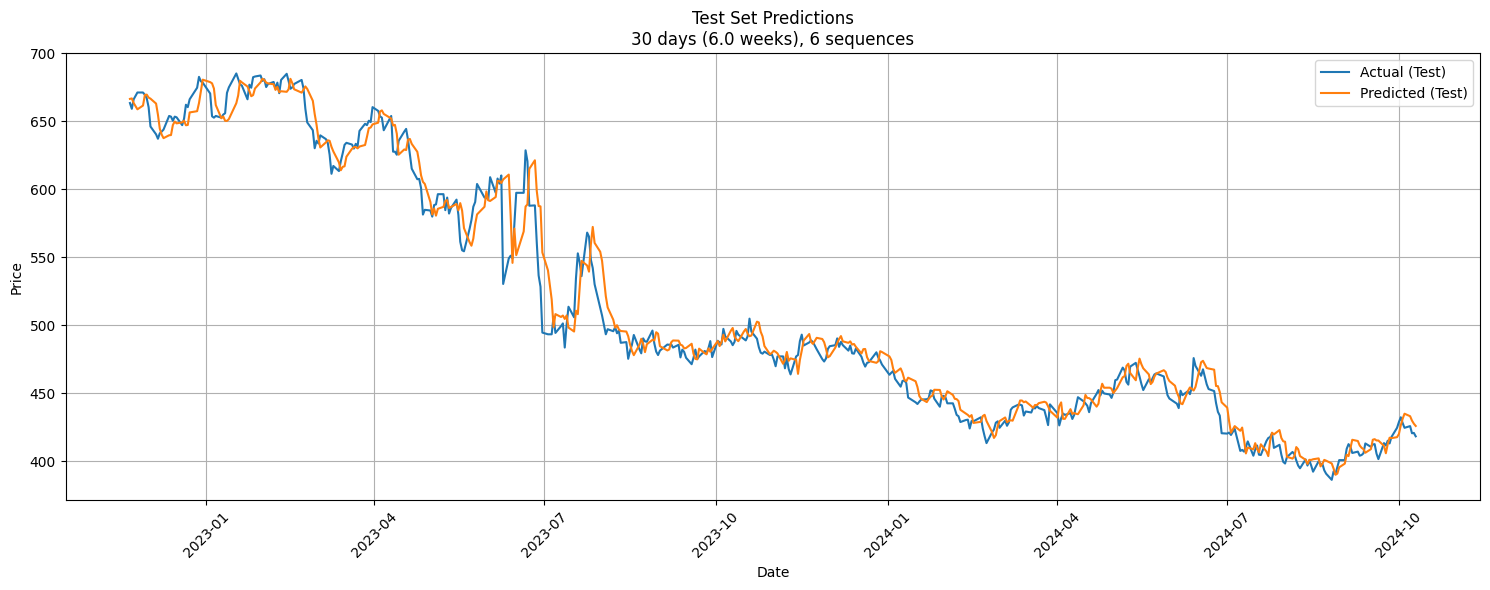

In [16]:
results_n_steps_experiments = n_steps_experiments(df)

In [17]:
results_n_steps_experiments = pd.DataFrame(results_n_steps_experiments)

In [18]:
results_n_steps_experiments

,n_steps,weeks,n_seq,weeks_per_seq,Val MAE,Val RMSE,Val R2,Val MAPE,Test MAE,Test RMSE,Test R2,Test MAPE
0,5,1.0,1,1.0,13.404014,18.017908,0.953517,2.174349,8.786294,12.785748,0.980463,1.701196
1,10,2.0,2,1.0,13.272620,17.631719,0.954780,2.145709,8.651763,12.672173,0.980730,1.673676
2,15,3.0,3,1.0,13.220928,17.690296,0.954102,2.138656,9.062549,13.263285,0.978806,1.764497
3,20,4.0,4,1.0,13.168772,17.673838,0.953576,2.128122,8.806970,13.038405,0.979433,1.704146
4,30,6.0,6,1.0,13.458464,18.135052,0.950421,2.168733,9.265101,13.338268,0.978383,1.807208


## Result

Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0275 - mae: 0.1490 - val_loss: 0.0017 - val_mae: 0.0482
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6110e-04 - mae: 0.0268 - val_loss: 0.0021 - val_mae: 0.0560
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4502e-04 - mae: 0.0246 - val_loss: 0.0017 - val_mae: 0.0496
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5404e-04 - mae: 0.0219 - val_loss: 0.0015 - val_mae: 0.0444
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7306e-04 - mae: 0.0197 - val_loss: 0.0013 - val_mae: 0.0407
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6570e-04 - mae: 0.0202 - val_loss: 0.0012 - val_mae: 0.0356
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4230e-04 - mae: 0.0192 - val_loss: 0.0013 - val_mae: 0.0422
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9001e-04 - mae: 0.0201 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 9/500
70/70 ━━━━━━━━━━━━━━━━━━

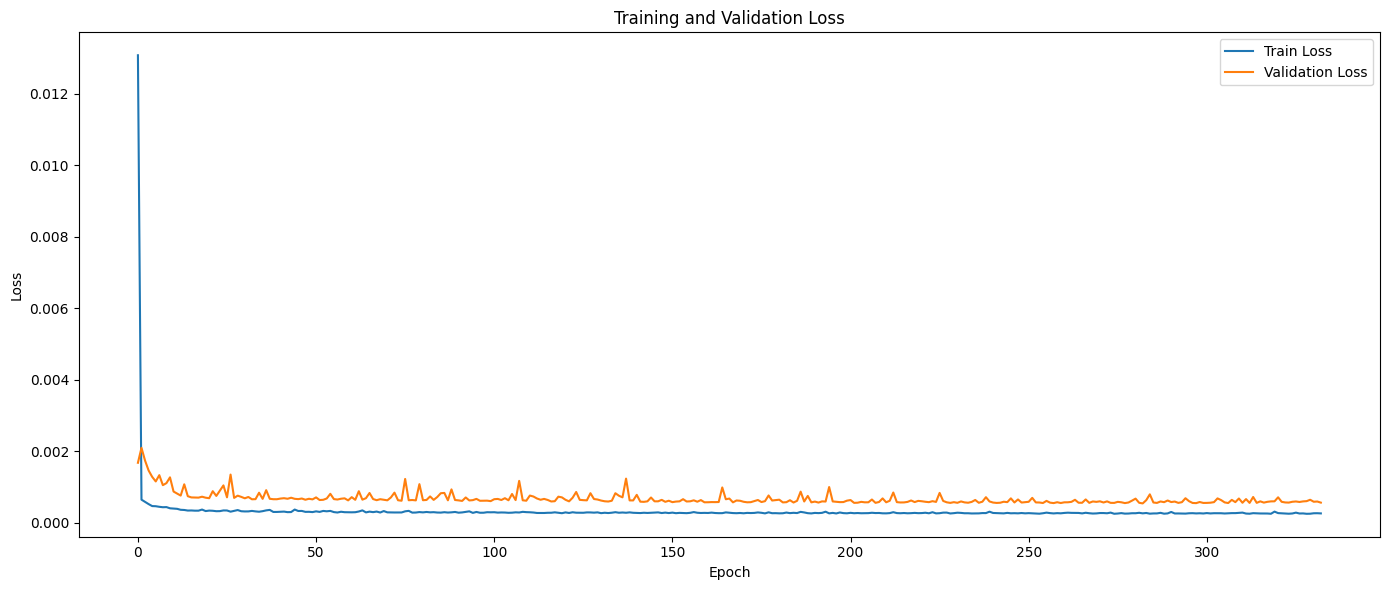

<bound method Model.summary of <Sequential name=sequential_5, built=True>>


In [19]:
model_cnnlstm, predictor_cnnlstm, history_cnnlstm, X_train_cnnlstm, y_train_cnnlstm, X_val_cnnlstm, y_val_cnnlstm, X_test_cnnlstm, y_test_cnnlstm = CNNLSTMforecasting(df, n_steps= 10, n_seq= 2)



In [58]:
model_cnnlstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ (None, 2, 3, 128)      │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 2, 1, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 2, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,091 (426.14 KB)

 Trainable params: 36,363 (142.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,728 (284.10 KB)

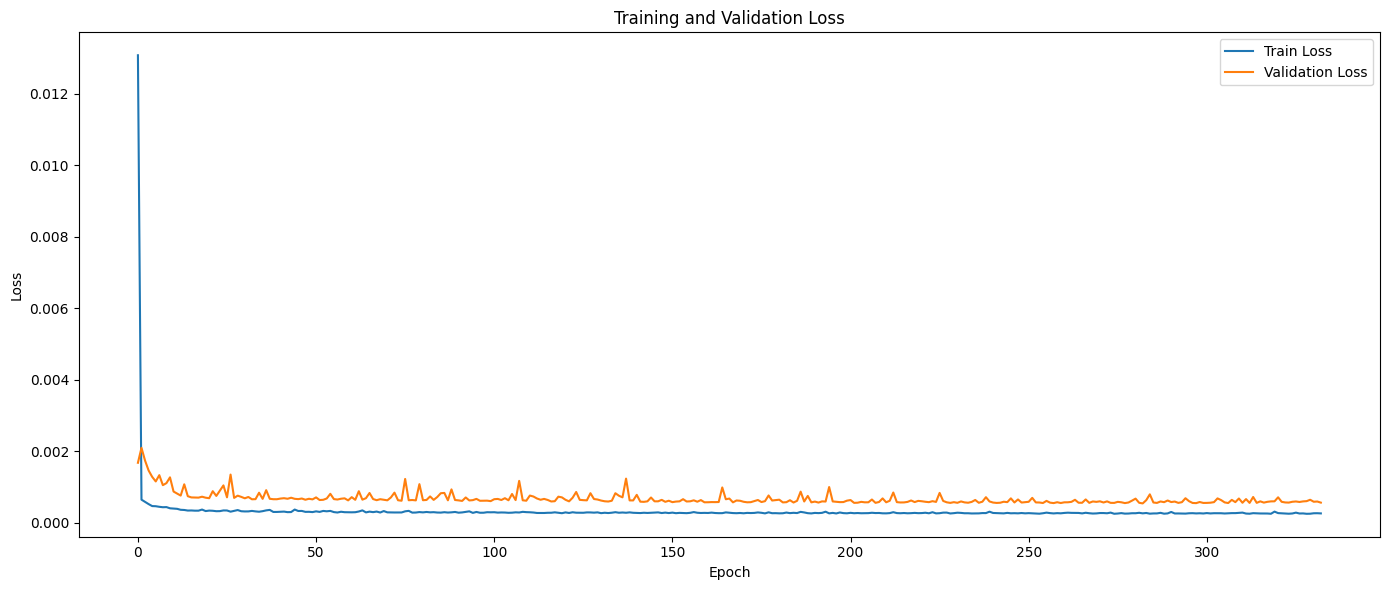

In [20]:
# Train and evaluate: loss over epoch
predictor_cnnlstm.plot_loss_by_epoch(history_cnnlstm)

In [21]:
# Result
y_test_orig_cnnlstm, test_pred_scaled_cnnlstm = predictor_cnnlstm.forecasting_result(model_cnnlstm, X_test_cnnlstm, y_test_cnnlstm)
mae_cnnlstm, rmse_cnnlstm, r2_cnnlstm, mape_cnnlstm = model_metrics(y_test_orig_cnnlstm, test_pred_scaled_cnnlstm)
print(f"MAE: {mae_cnnlstm}, RMSE: {rmse_cnnlstm}, R2: {r2_cnnlstm}, MAPE: {mape_cnnlstm}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
MAE: 8.63582563200755, RMSE: 12.71307816145999, R2: 0.9806052558898685, MAPE: 1.6711981894235752


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step

Training Set Predictions:


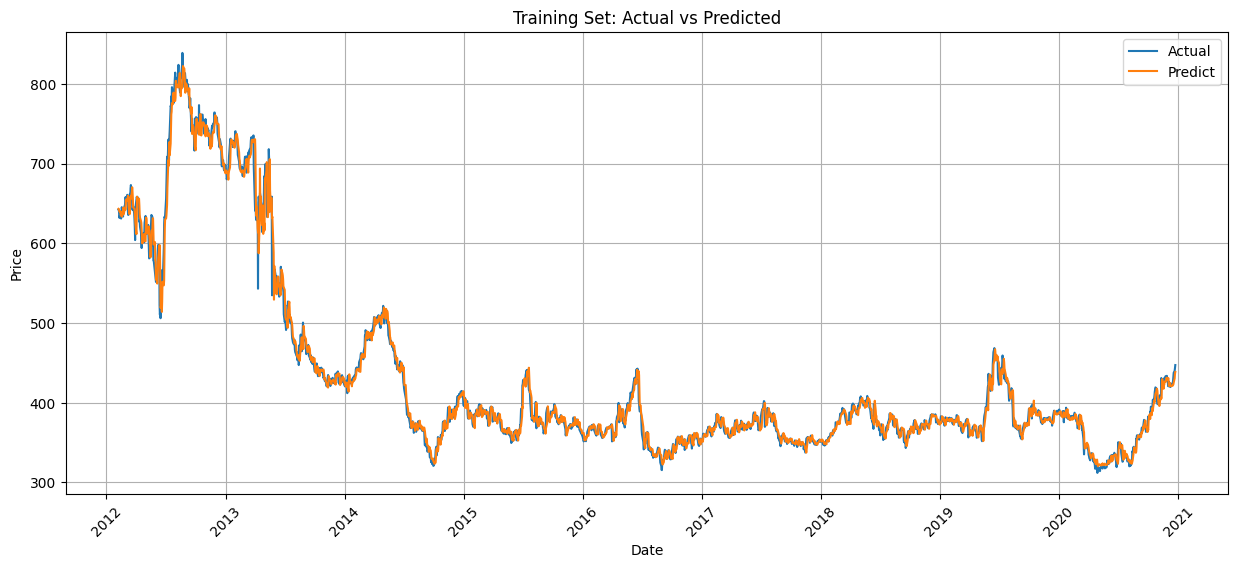

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step

Validation Set Predictions:


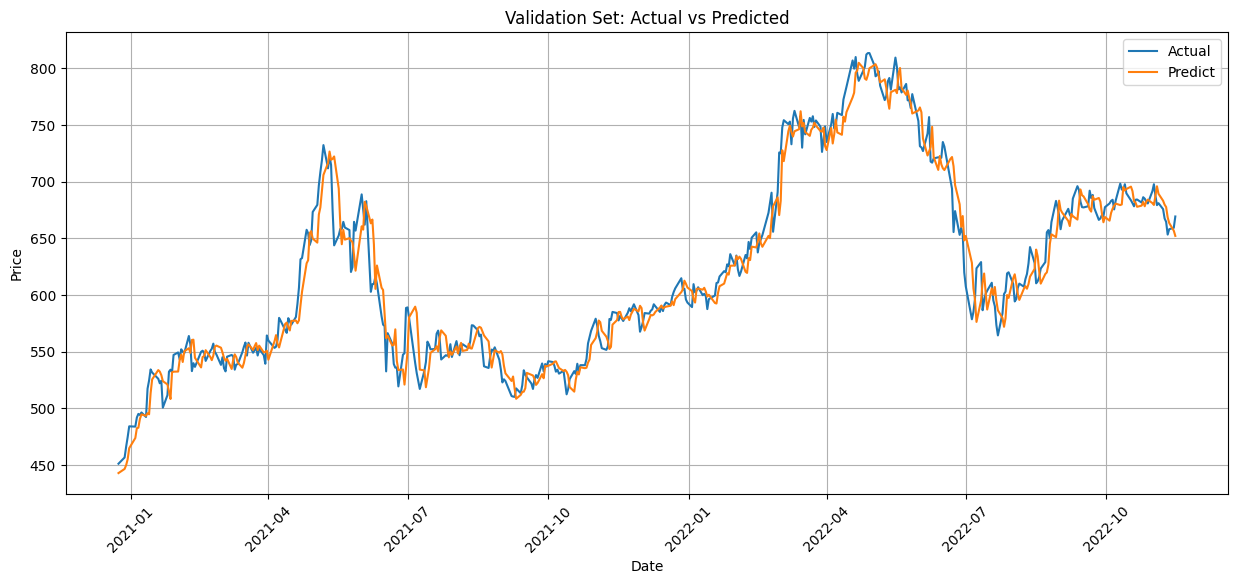

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step

Test Set Predictions:


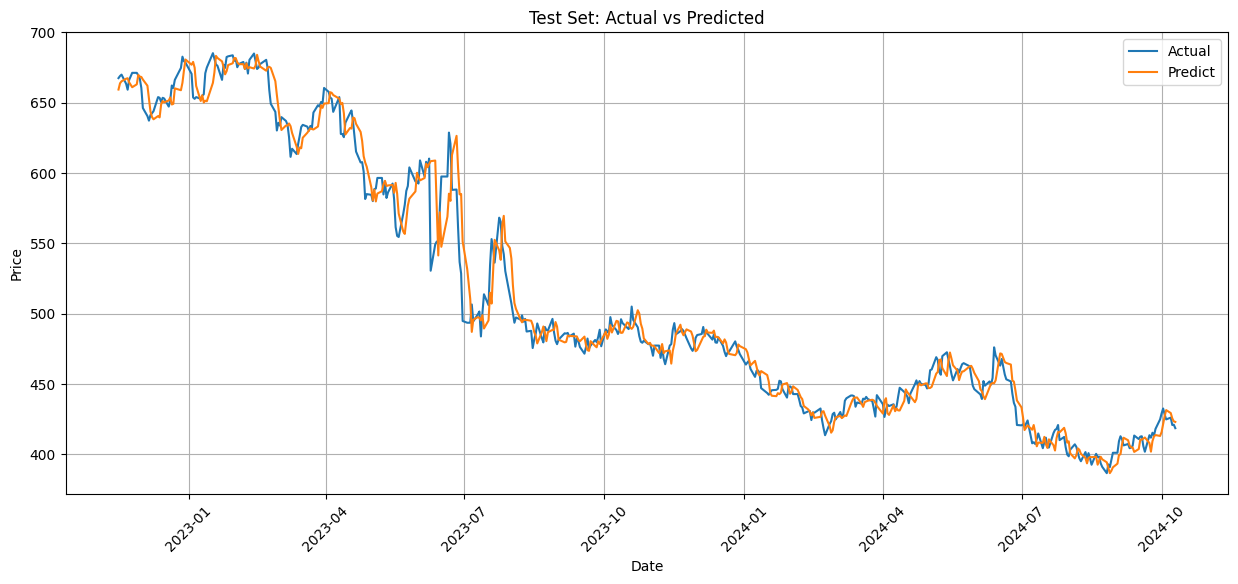

In [22]:
predictor_cnnlstm.plot_train_validation_test_forecasting(model_cnnlstm)

## Forecast

In [23]:
result_df_cnnlstm = create_forecasting_dataframe(df, model_cnnlstm, predictor_cnnlstm, X_train_cnnlstm, X_val_cnnlstm, X_test_cnnlstm)
result_df_cnnlstm

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


,date,actual,predict_CNNLSTM
0,2012-02-07,642.25,643.174011
1,2012-02-08,642.50,642.773010
2,2012-02-09,637.00,641.365784
3,2012-02-10,631.75,639.673889
4,2012-02-13,639.50,640.016418
...,...,...,...
3236,2024-12-25,NaN,310.319611
3237,2024-12-26,NaN,310.319611
3238,2024-12-27,NaN,310.319611
3239,2024-12-30,NaN,310.319611


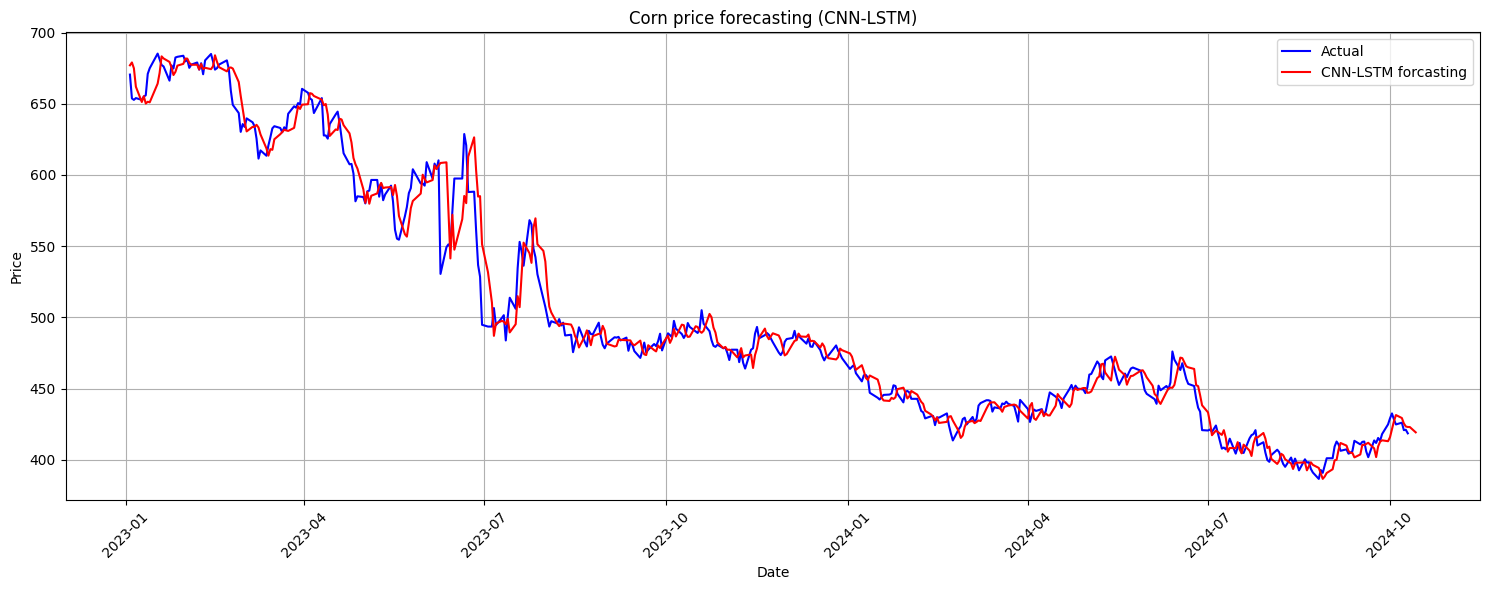

In [24]:
# Lọc dữ liệu từ năm 2023 trở đi
plot_df = result_df_cnnlstm[(result_df_cnnlstm['date'] >= '2023-01-01') & (result_df_cnnlstm['date'] <= '2024-10-14')]

plt.figure(figsize=(15, 6))

# Vẽ đường thực tế
plt.plot(plot_df['date'], plot_df['actual'], label='Actual', color='blue')

# Vẽ đường dự đoán với màu đỏ
plt.plot(plot_df['date'], plot_df['predict_CNNLSTM'], label='CNN-LSTM forcasting', color='red')

# Thiết lập tiêu đề và nhãn
plt.title("Corn price forecasting (CNN-LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MLP

In [4]:
class MLPPredictor:
    def __init__(self, n_steps=10, n_features=1):
        self.n_steps = n_steps
        self.n_features = n_features
        self.scaler = MinMaxScaler()
        
    def create_sequences(self, data):
        """Create sequences for MLP input"""
        length = len(data)
        X = np.array([data[i:i+self.n_steps] for i in range(length-self.n_steps)])
        y = np.array([data[i+self.n_steps] for i in range(length-self.n_steps)])
        # Flatten the input for MLP
        return X.reshape((X.shape[0], self.n_steps * self.n_features)), y.ravel()
    
    def prepare_data(self, df, train_size=0.7, val_size=0.15):
        """Prepare and split data into train, validation and test sets"""
        
        # Process date column
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
        # Process price column
        prices = df['close'].values.reshape(-1, 1)
        scaled_prices = self.scaler.fit_transform(prices)
        
        X, y = self.create_sequences(scaled_prices)
        
        # Split data
        train_end = int(len(X) * train_size)
        val_end = int(len(X) * (train_size + val_size))
        
        self.X_train, self.y_train = X[:train_end], y[:train_end]
        self.X_val, self.y_val = X[train_end:val_end], y[train_end:val_end]
        self.X_test, self.y_test = X[val_end:], y[val_end:]
        
        self.dates = df['date'].values[self.n_steps:]
        self.train_dates = self.dates[:train_end]
        self.val_dates = self.dates[train_end:val_end]
        self.test_dates = self.dates[val_end:]
        
        return (self.X_train, self.y_train), (self.X_val, self.y_val), (self.X_test, self.y_test)
    
    def build_model(self, hidden_layers=(100, 50), activation='relu', 
                   max_iter=1000, learning_rate_init=0.001):
        """Build sklearn MLPRegressor model"""
        return MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            activation=activation,
            solver='adam',
            max_iter=max_iter,
            learning_rate_init=learning_rate_init,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=50,
            verbose=True
        )
    
    def evaluate_predictions(self, y_true, y_pred):
        """Calculate various metrics for model evaluation"""
        # Convert predictions back to original scale
        y_true_orig = self.scaler.inverse_transform(y_true.reshape(-1, 1))
        y_pred_orig = self.scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        # Calculate metrics
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        rmse = root_mean_squared_error(y_true_orig, y_pred_orig)
        r2 = r2_score(y_true_orig, y_pred_orig)
        mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
        
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R2 Score: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")
        
        return mae, rmse, r2, mape
    
    def plot_forcasting(self, dates, y_true, y_pred, title):
        """Plot actual vs predicted values"""
        # Convert to original scale
        y_true_orig = self.scaler.inverse_transform(y_true.reshape(-1, 1))
        y_pred_orig = self.scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        plt.figure(figsize=(14, 6))
        plt.plot(dates, y_true_orig, label='Actual', alpha=0.8)
        plt.plot(dates, y_pred_orig, label='Predicted', alpha=0.8)
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_train_validation_test_forecasting(self, model):
        """Plot and evaluate predictions for all datasets"""
        # Training set
        train_pred = model.predict(self.X_train)
        print("\nTraining Set Metrics:")
        self.evaluate_predictions(self.y_train, train_pred)
        self.plot_forcasting(self.train_dates, self.y_train, train_pred,
                            "Training Set: Actual vs Predicted (MLP)")
        
        # Validation set
        val_pred = model.predict(self.X_val)
        print("\nValidation Set Metrics:")
        self.evaluate_predictions(self.y_val, val_pred)
        self.plot_forcasting(self.val_dates, self.y_val, val_pred,
                            "Validation Set: Actual vs Predicted (MLP)")
        
        # Test set
        test_pred = model.predict(self.X_test)
        print("\nTest Set Metrics:")
        self.evaluate_predictions(self.y_test, test_pred)
        self.plot_forcasting(self.test_dates, self.y_test, test_pred,
                            "Test Set: Actual vs Predicted (MLP)")

    def forecast_future(self, model, last_sequence, n_predictions=30):
        """Dự đoán giá trị tương lai dựa trên sequence cuối cùng"""
        predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_predictions):
            # Dự đoán bước tiếp theo
            pred = model.predict(current_sequence.reshape(1, -1))
            predictions.append(pred[0])

            # Chuẩn hóa giá trị dự đoán để đưa vào sequence tiếp theo
            pred_scaled = self.scaler.transform(pred.reshape(-1, 1))
            
            # Dịch sequence sang trái và thêm giá trị dự đoán vào cuối
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[-1] = pred_scaled[0, 0]

        # Chuyển đổi dự đoán về thang đo gốc
        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        return predictions

def create_MLP_prediction_dataframe(df, model, predictor, X_train, X_val, X_test):
    # Dự đoán cho các tập train, validation và test
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)

    # Biến đổi ngược lại giá trị dự đoán về thang đo gốc
    train_predictions = predictor.scaler.inverse_transform(train_predictions.reshape(-1, 1))
    val_predictions = predictor.scaler.inverse_transform(val_predictions.reshape(-1, 1))
    test_predictions = predictor.scaler.inverse_transform(test_predictions.reshape(-1, 1))
    
    # Lấy ngày tương ứng với từng tập dữ liệu
    train_dates = predictor.train_dates
    val_dates = predictor.val_dates
    test_dates = predictor.test_dates

    train_df = pd.DataFrame({
        'date': train_dates,
        'actual': df.loc[df['date'].isin(train_dates), 'close'].values,
        'predict_MLP': train_predictions.flatten()
    })
    val_df = pd.DataFrame({
        'date': val_dates,
        'actual': df.loc[df['date'].isin(val_dates), 'close'].values,
        'predict_MLP': val_predictions.flatten()
    })
    test_df = pd.DataFrame({
        'date': test_dates,
        'actual': df.loc[df['date'].isin(test_dates), 'close'].values,
        'predict_MLP': test_predictions.flatten()
    })
    
    # Kết hợp dữ liệu lịch sử
    historical_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    # Dự đoán cho các ngày tương lai
    last_sequence = X_test[-1]  # Sử dụng sequence cuối cùng trong tập kiểm tra
    future_dates = pd.date_range(start='2024-10-11', end='2024-12-31', freq='B')  # 'B' là ngày làm việc
    future_predictions = predictor.forecast_future(model, last_sequence, len(future_dates))

    # Tạo dataframe cho dự đoán tương lai
    future_df = pd.DataFrame({
        'date': future_dates,
        'actual': np.nan,
        'predict_MLP': future_predictions.flatten()
    })

    # Kết hợp dữ liệu lịch sử và dự đoán tương lai
    result_df = pd.concat([historical_df, future_df], ignore_index=True)
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values('date').reset_index(drop=True)
    
    return result_df

def MLPforecasting(df, n_steps=10):
    """Main function to train sklearn MLP model and make predictions"""
    predictor = MLPPredictor(n_steps=n_steps)
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = predictor.prepare_data(df)
    
    model = predictor.build_model()
    model.fit(X_train, y_train)
    
    # Plot and evaluate results
    predictor.plot_train_validation_test_forecasting(model)
    
    return model, predictor, X_train, y_train, X_val, y_val, X_test, y_test

Iteration 1, loss = 0.01303663
Validation score: 0.972464
Iteration 2, loss = 0.00105989
Validation score: 0.950630
Iteration 3, loss = 0.00078943
Validation score: 0.983711
Iteration 4, loss = 0.00057932
Validation score: 0.984332
Iteration 5, loss = 0.00047968
Validation score: 0.984595
Iteration 6, loss = 0.00040292
Validation score: 0.989443
Iteration 7, loss = 0.00035126
Validation score: 0.990269
Iteration 8, loss = 0.00035276
Validation score: 0.989413
Iteration 9, loss = 0.00030714
Validation score: 0.991160
Iteration 10, loss = 0.00028568
Validation score: 0.991497
Iteration 11, loss = 0.00027761
Validation score: 0.991912
Iteration 12, loss = 0.00027955
Validation score: 0.992669
Iteration 13, loss = 0.00024244
Validation score: 0.993052
Iteration 14, loss = 0.00024070
Validation score: 0.993639
Iteration 15, loss = 0.00023113
Validation score: 0.992467
Iteration 16, loss = 0.00023047
Validation score: 0.993913
Iteration 17, loss = 0.00021047
Validation score: 0.994599
Iterat

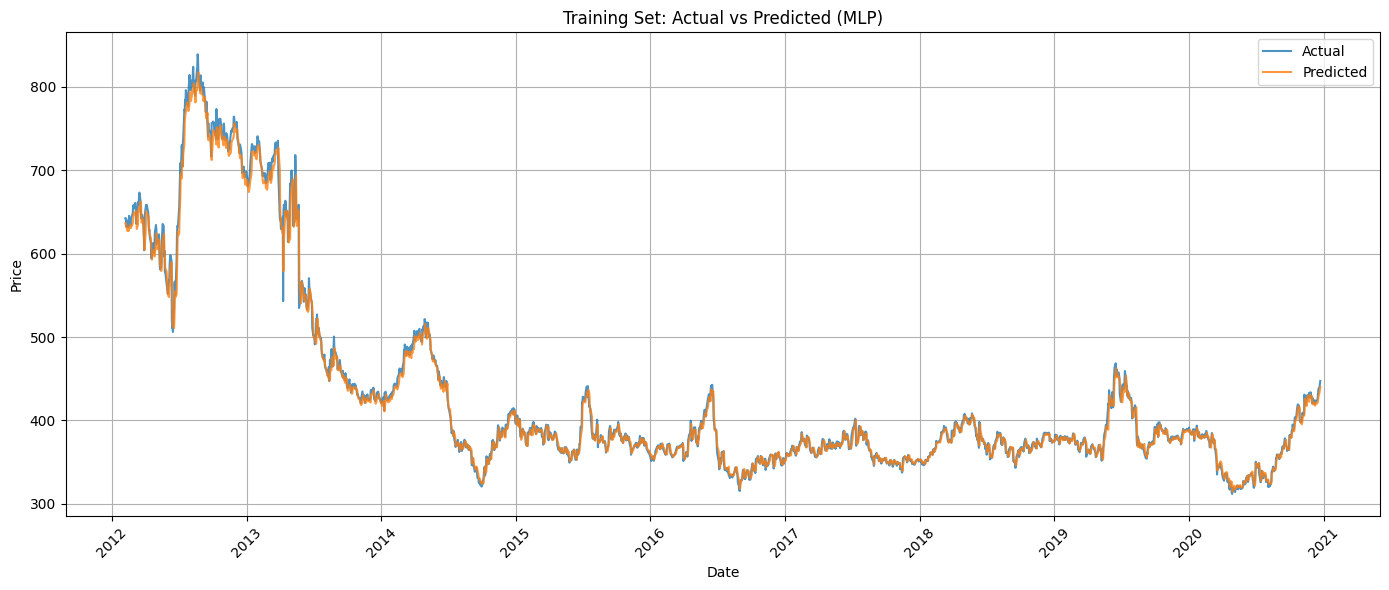


Validation Set Metrics:
MAE: 11.38
RMSE: 14.68
R2 Score: 0.9687
MAPE: 1.82%


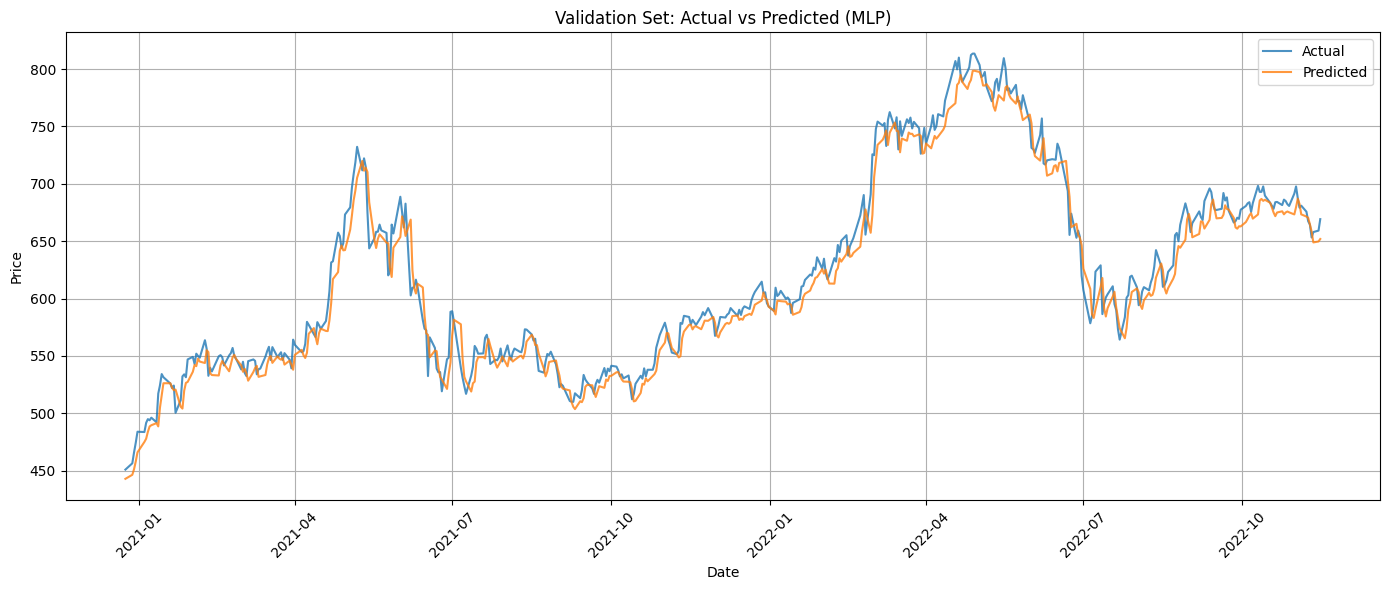


Test Set Metrics:
MAE: 7.07
RMSE: 9.77
R2 Score: 0.9886
MAPE: 1.35%


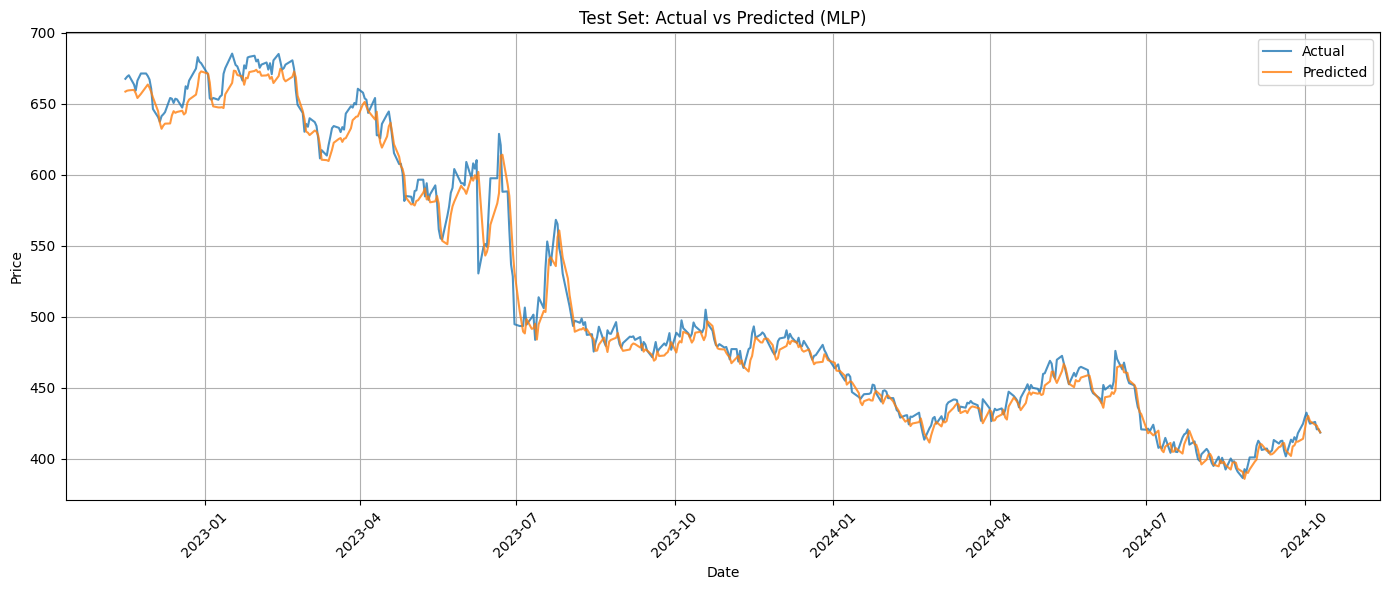

In [5]:
model_mlp, predictor_mlp, X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp, X_test_mlp, y_test_mlp = MLPforecasting(df)

In [43]:
y_pred_test_mlp = model_mlp.predict(X_test_mlp)

mae_mlp, rmse_mlp, r2_mlp, mape_mlp = predictor_mlp.evaluate_predictions(y_test_mlp, y_pred_test_mlp)


MAE: 7.07
RMSE: 9.77
R2 Score: 0.9886
MAPE: 1.35%


In [27]:
result_df_mlp = create_MLP_prediction_dataframe(df, model_mlp, predictor_mlp, X_train_mlp, X_val_mlp, X_test_mlp)
result_df_mlp

,date,actual,predict_MLP
0,2012-02-07,642.25,636.252208
1,2012-02-08,642.50,634.694919
2,2012-02-09,637.00,635.356031
3,2012-02-10,631.75,631.905108
4,2012-02-13,639.50,626.944378
...,...,...,...
3236,2024-12-25,NaN,234.178643
3237,2024-12-26,NaN,234.178643
3238,2024-12-27,NaN,234.178643
3239,2024-12-30,NaN,234.178643


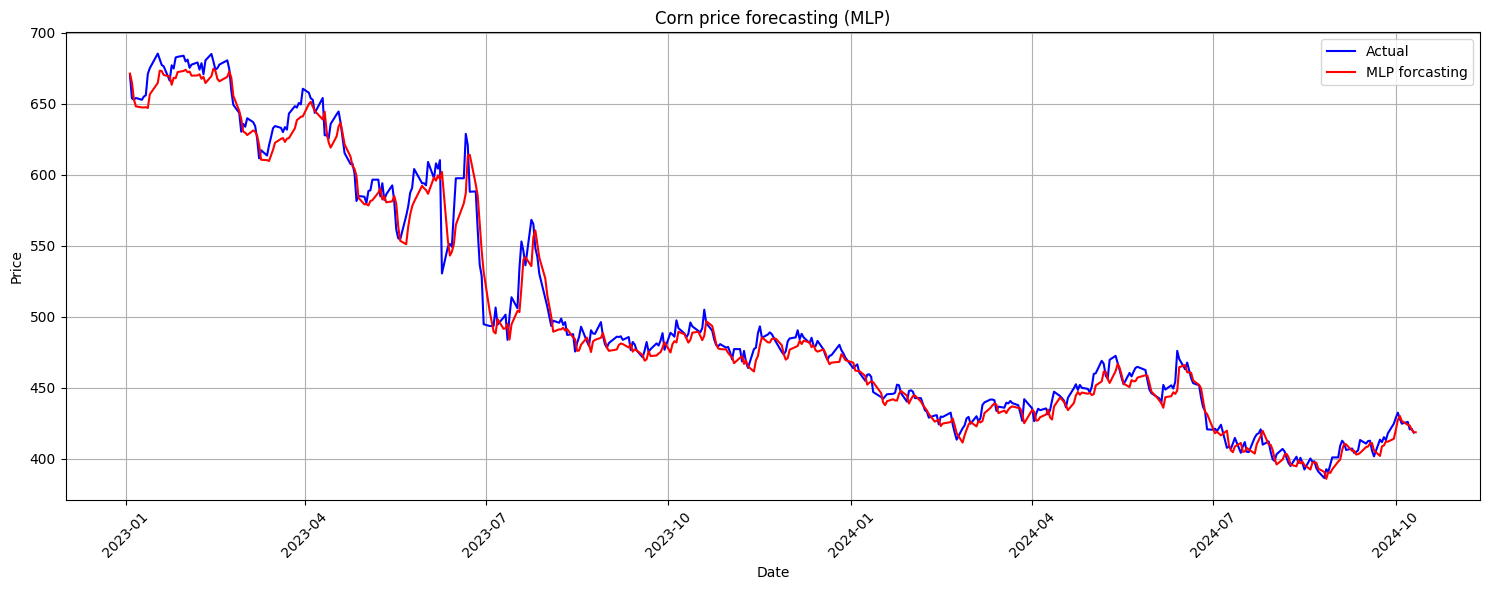

In [28]:
# Lọc dữ liệu từ năm 2023 trở đi
plot_df = result_df_mlp[(result_df_mlp['date'] >= '2023-01-01') & (result_df_mlp['date'] <= '2024-10-13')]

plt.figure(figsize=(15, 6))

# Vẽ đường thực tế
plt.plot(plot_df['date'], plot_df['actual'], label='Actual', color='blue')

# Vẽ đường dự đoán với màu đỏ
plt.plot(plot_df['date'], plot_df['predict_MLP'], label='MLP forcasting', color='red')

# Thiết lập tiêu đề và nhãn
plt.title("Corn price forecasting (MLP)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# KNN

In [47]:
class KNNPredictor:
    def __init__(self, n_steps=10, n_neighbors=5):
        self.n_steps = n_steps
        self.n_neighbors = n_neighbors
        self.scaler = MinMaxScaler()
        
    def create_sequences(self, data):
        """Create sequences from time series data"""
        X, y = [], []
        for i in range(len(data) - self.n_steps):
            X.append(data[i:(i + self.n_steps), 0])
            y.append(data[i + self.n_steps, 0])
        return np.array(X), np.array(y)
    
    def prepare_data(self, df, train_size=0.7, val_size=0.15):
        """Prepare and split data into train, validation and test sets"""
        
        # Process date column
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
        # Process price column
        prices = df['close'].values.reshape(-1, 1)
        scaled_prices = self.scaler.fit_transform(prices)
        
        # Create sequences
        X, y = self.create_sequences(scaled_prices)
        
        # Split data into train, validation, test sets
        train_end = int(len(X) * train_size)
        val_end = int(len(X) * (train_size + val_size))
        
        self.X_train, self.y_train = X[:train_end], y[:train_end]
        self.X_val, self.y_val = X[train_end:val_end], y[train_end:val_end]
        self.X_test, self.y_test = X[val_end:], y[val_end:]
        
        # Store dates for plotting
        self.dates = df['date'].values[self.n_steps:]
        self.train_dates = self.dates[:train_end]
        self.val_dates = self.dates[train_end:val_end]
        self.test_dates = self.dates[val_end:]
        
        return (self.X_train, self.y_train), (self.X_val, self.y_val), (self.X_test, self.y_test)

    def build_model(self, weights='uniform', algorithm='auto', leaf_size=30):
        """Build KNN model with given parameters"""
        model = KNeighborsRegressor(
            n_neighbors=self.n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size
        )
        return model
    
    def train_model(self, model, X_train, y_train):
        history = model.fit(X_train, y_train)
        return history
    
    def evaluate_model(self, model, X, y):
        """Evaluate model performance"""
        # Make predictions
        predictions = model.predict(X)
        
        # Convert predictions and actual values back to original scale
        actual = self.scaler.inverse_transform(y.reshape(-1, 1))
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1))
        
        mae = mean_absolute_error(actual, predictions)
        rmse = root_mean_squared_error(actual, predictions)
        r2 = r2_score(actual, predictions)
        mape = mean_absolute_percentage_error(actual, predictions)

        return actual, predictions, {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}
    
    def plot_forcasting(self, dates, y_true, y_pred, title='Model Predictions vs Actual Values'):
        """Plot predictions against actual values with dates"""
        plt.figure(figsize=(15, 6))
        plt.plot(dates, y_true, label='Actual', color='blue')
        plt.plot(dates, y_pred, label='Predicted', color='red', alpha=0.7)
        
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_train_validation_test_forecasting(self, model):
        """Plot predictions for all datasets"""
        # Training set
        y_train_orig, train_pred, train_metrics = self.evaluate_model(model, self.X_train, self.y_train)
        print("\nTraining Set Metrics:")
        print(f"RMSE: {train_metrics['rmse']:.2f}")
        print(f"MAE: {train_metrics['mae']:.2f}")
        self.plot_forcasting(self.train_dates, y_train_orig, train_pred, 
                            "Training Set: Actual vs Predicted")
        
        # Validation set
        y_val_orig, val_pred, val_metrics = self.evaluate_model(model, self.X_val, self.y_val)
        print("\nValidation Set Metrics:")
        print(f"RMSE: {val_metrics['rmse']:.2f}")
        print(f"MAE: {val_metrics['mae']:.2f}")
        self.plot_forcasting(self.val_dates, y_val_orig, val_pred,
                            "Validation Set: Actual vs Predicted")
        
        # Test set
        y_test_orig, test_pred, test_metrics = self.evaluate_model(model, self.X_test, self.y_test)
        print("\nTest Set Metrics:")
        print(f"RMSE: {test_metrics['rmse']:.2f}")
        print(f"MAE: {test_metrics['mae']:.2f}")
        self.plot_forcasting(self.test_dates, y_test_orig, test_pred,
                            "Test Set: Actual vs Predicted")
    
    def forecast_future(self, model, last_sequence, n_predictions=30):
        """Make future predictions using the trained model"""
        predictions = []
        current_sequence = last_sequence.copy()
        
        for _ in range(n_predictions):
            # Make prediction
            pred = model.predict(current_sequence.reshape(1, -1))
            predictions.append(pred[0])
            
            # Update sequence: remove first element and append prediction
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[-1] = pred
            
        # Convert predictions back to original scale
        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        return predictions

def create_forecasting_dataframe(df, model, predictor, X_train, X_val, X_test):
    """Create a DataFrame containing all predictions"""
    # Make predictions
    _, train_predictions, _ = predictor.evaluate_model(model, X_train, predictor.y_train)
    _, val_predictions, _ = predictor.evaluate_model(model, X_val, predictor.y_val)
    _, test_predictions, _ = predictor.evaluate_model(model, X_test, predictor.y_test)
    
    # Create DataFrames for historical data
    train_df = pd.DataFrame({
        'date': predictor.train_dates,
        'actual': df.loc[df['date'].isin(predictor.train_dates), 'close'].values,
        'predict_KNN': train_predictions.flatten()
    })
    
    val_df = pd.DataFrame({
        'date': predictor.val_dates,
        'actual': df.loc[df['date'].isin(predictor.val_dates), 'close'].values,
        'predict_KNN': val_predictions.flatten()
    })
    
    test_df = pd.DataFrame({
        'date': predictor.test_dates,
        'actual': df.loc[df['date'].isin(predictor.test_dates), 'close'].values,
        'predict_KNN': test_predictions.flatten()
    })
    
    historical_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    
    # Make future predictions
    last_sequence = X_test[-1]
    future_dates = pd.date_range(start='2024-10-11', end='2024-12-31', freq='B')
    future_predictions = predictor.forecast_future(model, last_sequence, len(future_dates))
    
    future_df = pd.DataFrame({
        'date': future_dates,
        'actual': np.nan,
        'predict_KNN': future_predictions.flatten()
    })
    
    # Combine historical and future predictions
    result_df = pd.concat([historical_df, future_df], ignore_index=True)
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values('date').reset_index(drop=True)
    
    return result_df

def KNNforecasting(df, n_steps=30, n_neighbors=5):
    """Main function to train model and make predictions"""
    predictor = KNNPredictor(n_steps=n_steps, n_neighbors=n_neighbors)
    
    # Prepare data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = predictor.prepare_data(df)
    
    # Build and train model
    model = predictor.build_model()
    history = predictor.train_model(model, X_train, y_train)
    
    return model, predictor, history, X_train, y_train, X_val, y_val, X_test, y_test


Training Set Metrics:
RMSE: 8.18
MAE: 4.94


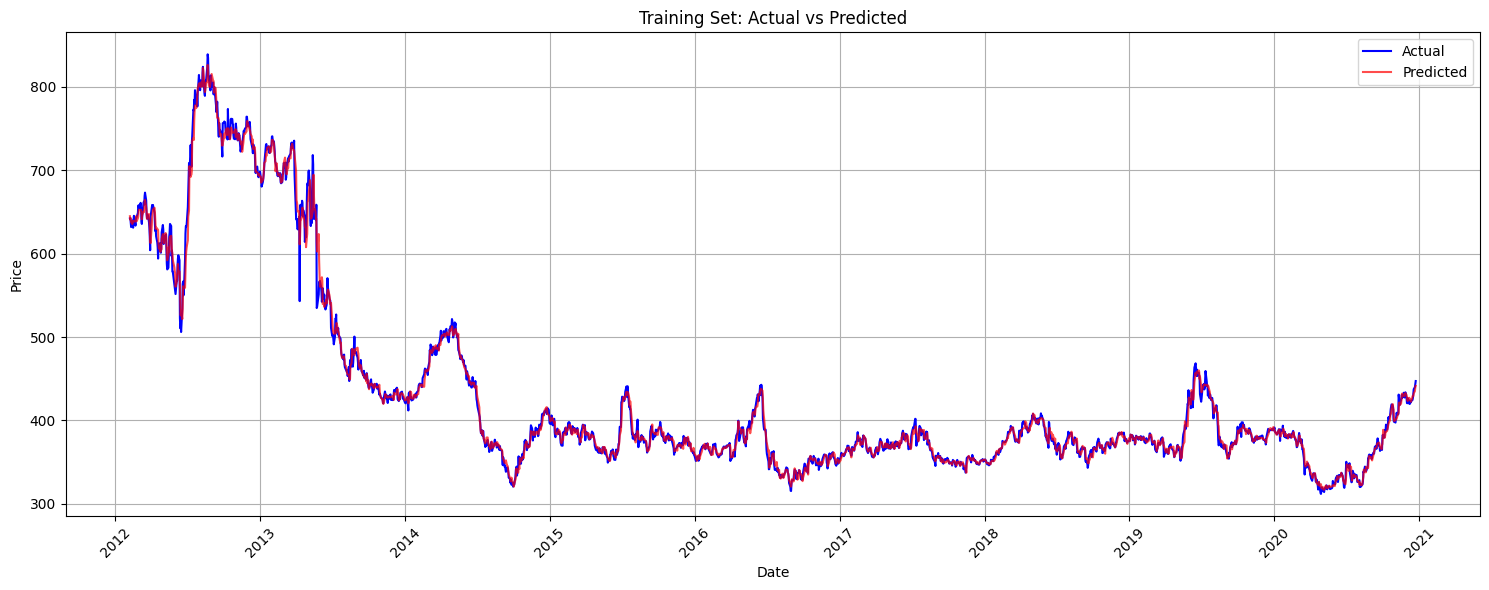


Validation Set Metrics:
RMSE: 20.43
MAE: 16.41


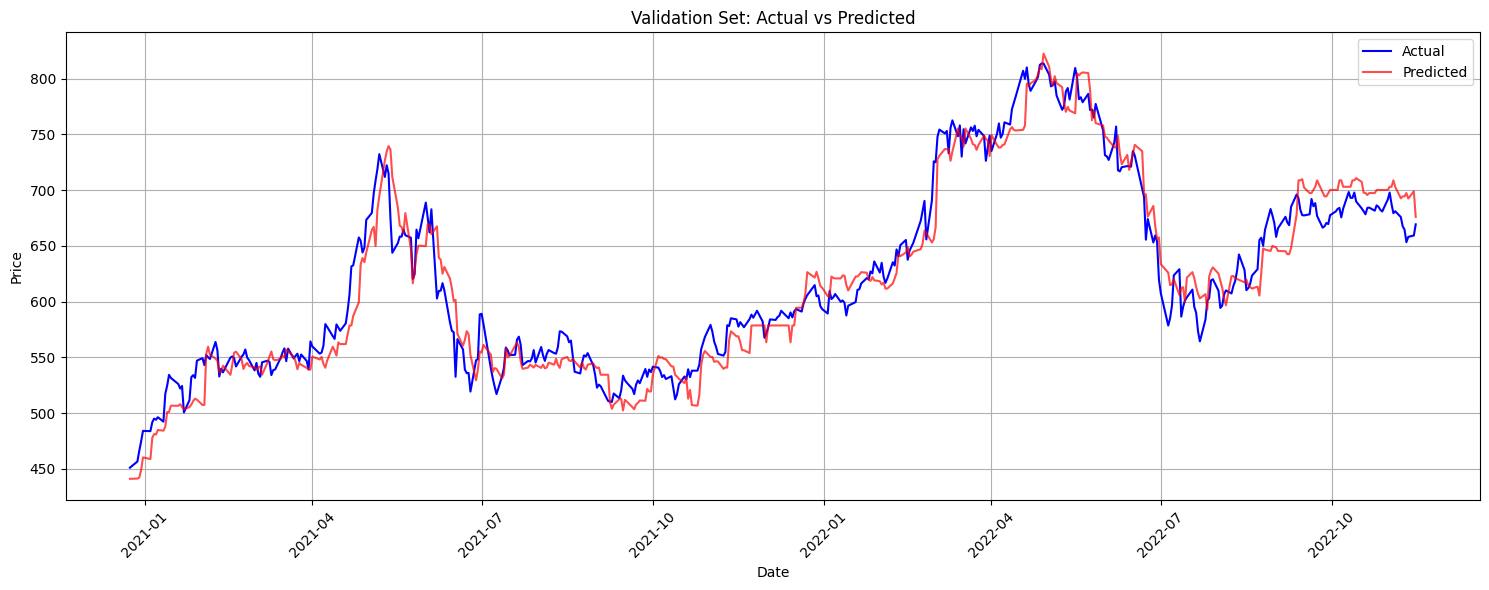


Test Set Metrics:
RMSE: 15.40
MAE: 10.87


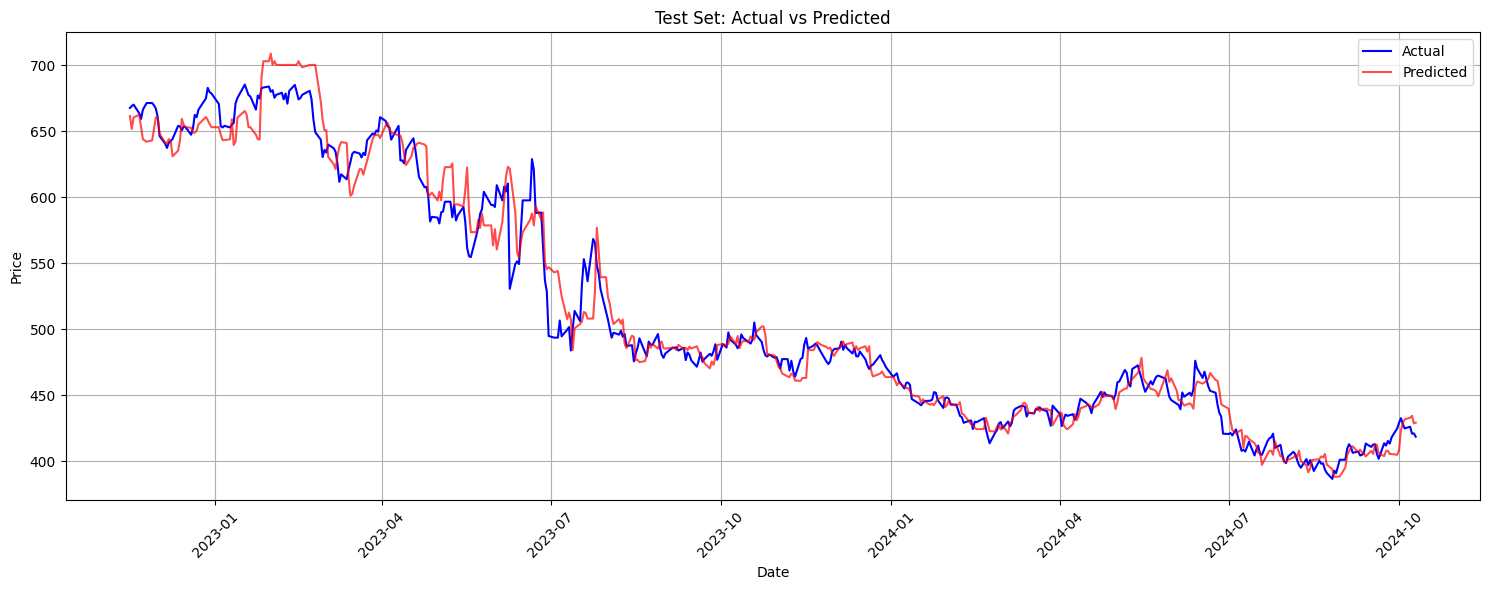

In [48]:
model_knn, predictor_knn, history_knn, X_train_knn, y_train_knn, X_val_knn, y_val_knn, X_test_knn, y_test_knn = KNNforecasting(df, n_steps=10, n_neighbors=5)

# Xem kết quả
predictor_knn.plot_train_validation_test_forecasting(model_knn)

# Tạo DataFrame dự đoán
results_df_knn = create_forecasting_dataframe(df, model_knn, predictor_knn, X_train_knn, X_val_knn, X_test_knn)

In [50]:
actual_knn, predictions_knn, metrics = predictor_knn.evaluate_model(model_knn, X_test_knn, y_test_knn)

In [52]:
mae_knn = metrics['mae']
rmse_knn = metrics['rmse']
r2_knn = metrics['r2']
mape_knn = metrics['mape']

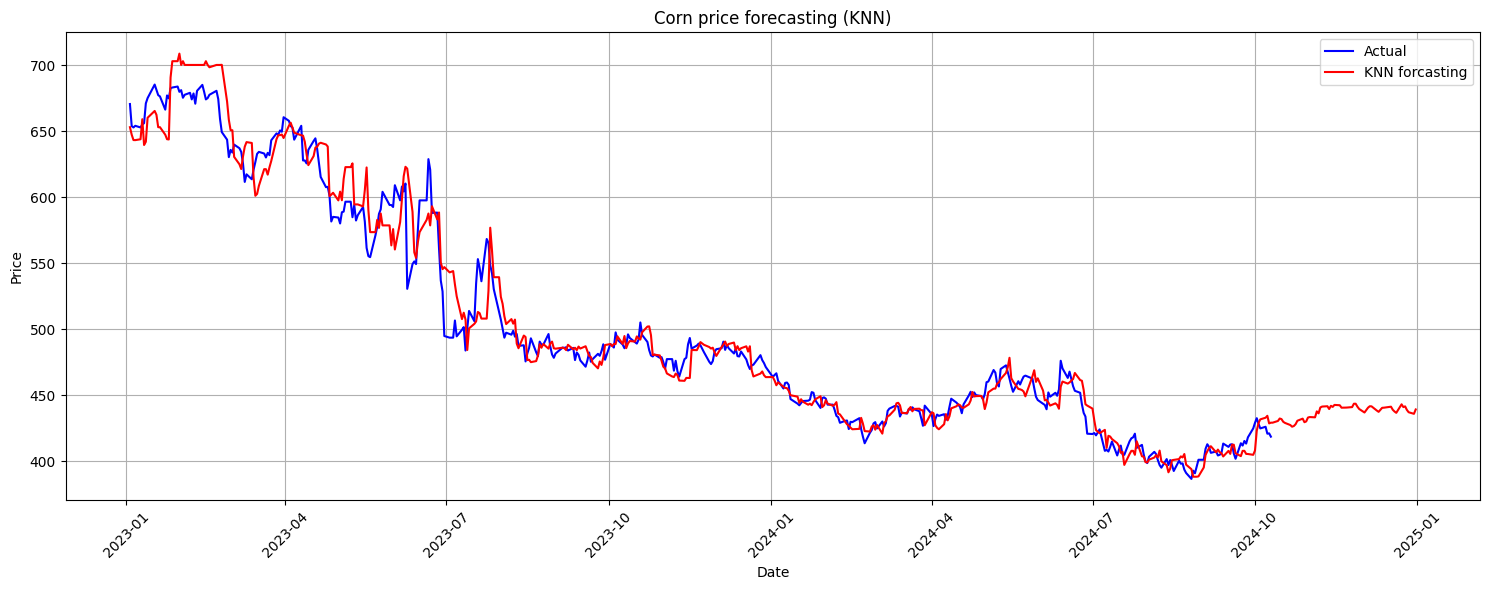

In [33]:
# Lọc dữ liệu từ năm 2023 trở đi
plot_df = results_df_knn[(result_df_mlp['date'] >= '2023-01-01') & (results_df_knn['date'] <= '2024-12-31')]

plt.figure(figsize=(15, 6))

# Vẽ đường thực tế
plt.plot(plot_df['date'], plot_df['actual'], label='Actual', color='blue')

# Vẽ đường dự đoán với màu đỏ
plt.plot(plot_df['date'], plot_df['predict_KNN'], label='KNN forcasting', color='red')

# Thiết lập tiêu đề và nhãn
plt.title("Corn price forecasting (KNN)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparison

In [38]:
result_df_cnnlstm = result_df_cnnlstm[(result_df_cnnlstm['date'] >= '2023-01-01') & (result_df_cnnlstm['date'] <= '2024-10-14')]
result_df_mlp = result_df_mlp[(result_df_mlp['date'] >= '2023-01-01') & (result_df_mlp['date'] <= '2024-10-13')]


In [39]:
result = pd.concat([result_df_cnnlstm, result_df_mlp, results_df_knn], axis = 1)
result = result.loc[:, ~result.columns.duplicated()]
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3241 entries, 2736 to 3240
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             449 non-null    datetime64[ns]
 1   actual           447 non-null    float64       
 2   predict_CNNLSTM  449 non-null    float32       
 3   predict_MLP      448 non-null    float64       
 4   predict_KNN      3241 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(3)
memory usage: 139.3 KB


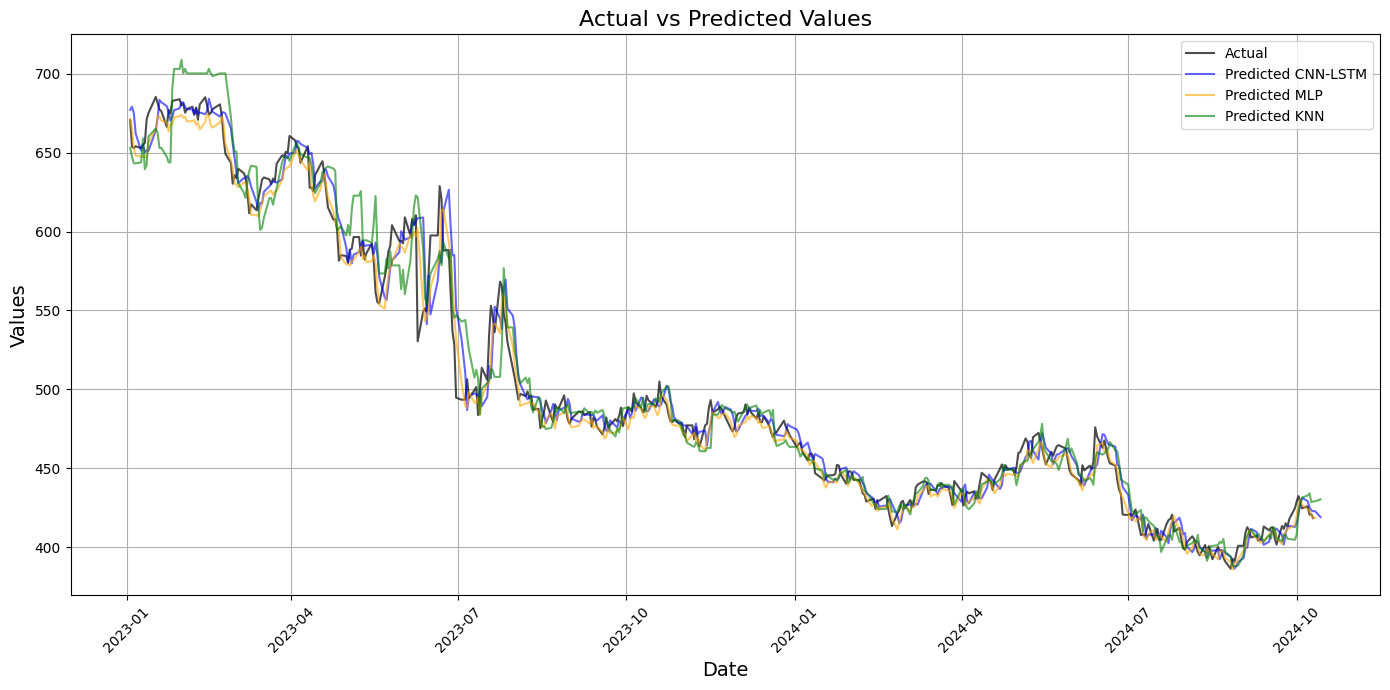

In [40]:
plt.figure(figsize=(14, 7))

plt.plot(result['date'], result['actual'], label='Actual', color='black', alpha=0.7)

plt.plot(result['date'], result['predict_CNNLSTM'], label='Predicted CNN-LSTM', color='blue', alpha=0.6)
plt.plot(result['date'], result['predict_MLP'], label='Predicted MLP', color='orange', alpha=0.6)
plt.plot(result['date'], result['predict_KNN'], label='Predicted KNN', color='green', alpha=0.6)

plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [55]:
metrics_data = {
    'Model': ['CNN-LSTM', 'KNN', 'MLP'],
    'MAE': [mae_cnnlstm, mae_knn, mae_mlp],
    'RMSE': [rmse_cnnlstm, rmse_knn, rmse_mlp],
    'R²': [r2_cnnlstm, r2_knn, r2_mlp],
    'MAPE': [mape_cnnlstm, mape_knn, mape_mlp]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df.set_index('Model', inplace=True)

metrics_df


,MAE,RMSE,R²,MAPE
Model,,,,
CNN-LSTM,8.635826,12.713078,0.980605,1.671198
KNN,10.866004,15.402998,0.971530,0.020323
MLP,7.070881,9.767014,0.988553,1.349183
